# Backtesting

In [ ]:
!pip install dotenv
!pip install boto3

In [37]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

from statsmodels.tsa.stattools import adfuller

import boto3
from dotenv import dotenv_values, find_dotenv

from io import StringIO
from tqdm import tqdm
from typing import Optional

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2, norm
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from io import StringIO
import boto3
from scipy.stats import t
from scipy import stats
from scipy.optimize import minimize


sns.set_style("darkgrid")
%config InlineBackend.figure_format='retina'

import warnings
warnings.filterwarnings("ignore")

# Start

In [2]:
def create_factor(factor_df: pd.DataFrame, pipe: Optional[Pipeline], n=1) -> np.array:
    """Понижение размерности факторов с помощью PCA."""
    if pipe is None:
        pipe = Pipeline([
            ('scaling', StandardScaler()),
            ('pca', PCA(n_components=n)),
        ])
        factor = pipe.fit_transform(factor_df)
    else:
        factor = pipe.transform(factor_df)
    factor = factor.squeeze()
    weights_pca = pd.Series(pipe.named_steps['pca'].components_[0], index=factor_df.columns)
    return pipe, factor, weights_pca

def create_weighted_factor(df, weights):
    """Создание взвешенного фактора из набора активов."""
    if isinstance(weights, dict):
        weights = pd.Series(weights)
    weights /= weights.sum()
    return (df * weights).sum(axis=1)

In [3]:
def multi_asset_gbm_simulations(S0_list, mu_list, sigma_list, corr_matrix, T, N, n_simulations=1000, seed=None):
    """Генерация траекторий для коррелированных активов."""
    if seed is not None:
        np.random.seed(seed)
    n_assets = len(S0_list)
    dt = T / N
    L = np.linalg.cholesky(corr_matrix)
    S = np.zeros((n_simulations, n_assets, N+1))
    S[:, :, 0] = S0_list
    for i in range(n_simulations):
        Z = np.random.standard_normal(size=(N, n_assets))
        dW = (Z @ L.T) * np.sqrt(dt)
        for j in range(1, N+1):
            drift = (mu_list - 0.5 * np.array(sigma_list)**2) * dt
            diffusion = np.array(sigma_list) * dW[j-1]
            S[i, :, j] = S[i, :, j-1] * np.exp(drift + diffusion)
    return S

In [4]:
def multi_asset_gbm_t_simulations_10d(S0_list, mu_list, sigma_list, corr_matrix, df, 
                                      n_simulations=10000, seed=None):
    """10-дневная GBM симуляция с t-распределением"""
    if seed is not None:
        np.random.seed(seed)
        
    n_assets = len(S0_list)
    T = 10/252 
    dt = 1/252   
    try:
        L = np.linalg.cholesky(corr_matrix)
    except np.linalg.LinAlgError:
        L = np.diag(np.ones(n_assets))
    
    S = np.zeros((n_simulations, n_assets, 11))
    S[:, :, 0] = S0_list
    
    for i in range(n_simulations):
        Z = t.rvs(df, size=(10, n_assets)) / np.sqrt(df/(df-2)) 
        
        dW = (Z @ L.T) * np.sqrt(dt)
        
        for j in range(1, 11):
            drift = (mu_list - 0.5 * np.array(sigma_list)**2) * dt
            diffusion = np.array(sigma_list) * dW[j-1]
            S[i, :, j] = S[i, :, j-1] * np.exp(drift + diffusion)
            
    return S

In [5]:
def multi_asset_gbm_t_simulations(S0_list, mu_list, sigma_list, corr_matrix, df, T, N, n_simulations=1000, seed=None):
    """GBM с t-распределением инноваций"""
    if seed is not None:
        np.random.seed(seed)
        
    n_assets = len(S0_list)
    dt = T / N
    L = np.linalg.cholesky(corr_matrix)
    
    t_inno = t.rvs(df, size=(n_simulations, N, n_assets))
    t_inno /= np.sqrt(df / (df - 2))  
    
    S = np.zeros((n_simulations, n_assets, N+1))
    S[:, :, 0] = S0_list
    
    for i in range(n_simulations):
        Z = t_inno[i] @ L.T
        
        for j in range(1, N+1):
            drift = (mu_list - 0.5 * np.array(sigma_list)**2) * dt
            diffusion = np.array(sigma_list) * Z[j-1] * np.sqrt(dt)
            S[i, :, j] = S[i, :, j-1] * np.exp(drift + diffusion)
    
    return S

# Tests

In [ ]:
def backtest_var(portfolio_type: str, actual_pnl: pd.Series, var_estimates: pd.Series):
    """Подсчет пробоев и проверка гипотезы."""
    exceptions = actual_pnl > var_estimates
    n_exceptions = exceptions.sum()
    n_obs = len(actual_pnl)
    exception_rate = n_exceptions / n_obs
    
    p_theoretical = 1 - 0.99  
    likelihood_ratio = -2 * np.log(
        ((1 - p_theoretical) ** (n_obs - n_exceptions) * p_theoretical ** n_exceptions) /
        ((1 - exception_rate) ** (n_obs - n_exceptions) * exception_rate ** n_exceptions)
    )
    p_value = 1 - chi2.cdf(likelihood_ratio, df=1)
    
    return n_exceptions, exception_rate, likelihood_ratio, p_value
def christoffersen_test(exceptions):
    n00, n01, n10, n11 = 0, 0, 0, 0
    
    for i in range(1, len(exceptions)):
        prev = exceptions[i-1]
        curr = exceptions[i]
        
        if prev == 0 and curr == 0: n00 += 1
        elif prev == 0 and curr == 1: n01 += 1
        elif prev == 1 and curr == 0: n10 += 1
        elif prev == 1 and curr == 1: n11 += 1

    if n00 + n01 == 0 or n10 + n11 == 0:
        return np.nan, np.nan 
    p0 = n01 / (n00 + n01) if (n00 + n01) > 0 else 0
    p1 = n11 / (n10 + n11) if (n10 + n11) > 0 else 0
    p = (n01 + n11) / (n00 + n01 + n10 + n11)
    
    l_num = ((1-p0)**n00 * p0**n01 * (1-p1)**n10 * p1**n11)
    l_den = ((1-p)**(n00+n10) * p**(n01+n11))

    if l_num == 0 and n00+n01+n10+n11 == 0:
        l_num = 1
    
    LR_ind = -2 * np.log(l_den / l_num)
    p_value = 1 - chi2.cdf(LR_ind, df=1)
    
    return LR_ind, p_value
def engle_manganelli_test(actual_loss, var_estimates, p=0.01, lags=1):
    """
    Engle & Manganelli (2004) CAViaR test (DQ test)
    H0: Модель VaR корректна (индикаторы пробоев независимы и имеют правильное среднее)
    """
    hits = (actual_loss > var_estimates).astype(float) - p
    
    n = len(hits)
    X = []
    
    X.append(np.ones(n))
    
    for lag in range(1, lags + 1):
        lagged_hits = np.zeros(n)
        lagged_hits[lag:] = hits[:-lag] 
        X.append(lagged_hits)
    
    X.append(var_estimates)

    X = np.column_stack(X)

    y = hits[lags:]
    X = X[lags:]
    
    if len(y) > 0:
        X_inv = np.linalg.pinv(X)
        beta = X_inv @ y
        
        residuals = y - X @ beta
        SSR = np.sum(residuals**2)  
        SST = np.sum((y - np.mean(y))**2) 
        R2 = 1 - SSR / SST if SST > 0 else 0
        
        DQ = len(y) * R2
        
        df = X.shape[1]
        p_value = 1 - chi2.cdf(DQ, df=df)
        
        return DQ, p_value
    else:
        return np.nan, np.nan
def haas_test(exceptions, alpha=0.01, smoothing=1e-6):
    """
    Реализация Duration-Based теста Haas (2006)
    """
    exceptions = np.asarray(exceptions)
    n = np.sum(exceptions)
    if n < 2:
        return None, None, "Недостаточно пробоев для расчёта"

    durations = []
    last = -1
    for i, val in enumerate(exceptions):
        if val == 1:
            if last != -1:
                durations.append(i - last)
            last = i

    durations = np.array(durations)
    S = durations.sum()
    mean_d = np.mean(durations)
    p = 1 / mean_d

    logL0 = len(durations) * np.log(p) + (S - len(durations)) * np.log(1 - p)

    counts = np.bincount(durations)[1:] 
    probs = counts / counts.sum()
    smoothed_counts = counts + smoothing
    smoothed_probs = smoothed_counts / smoothed_counts.sum()

    logL1 = np.sum(counts * np.log(smoothed_probs))

    LR_stat = -2 * (logL0 - logL1)
    p_val = 1 - chi2.cdf(LR_stat, df=1)


    return LR_stat, p_val
def christoffersen_pelletier_test(losses, var):
    """
    Duration-based тест Christoffersen & Pelletier (2004)
    """

    violations = losses > var
    violation_indices = np.where(violations)[0]

    if len(violation_indices) < 2:
        return np.nan, np.nan
    
    durations = np.diff(violation_indices)
    
    def exp_log_likelihood(lambda_param, d):
        return -np.sum(np.log(lambda_param) - lambda_param * d)
    
    def weibull_log_likelihood(params, d):
        a, b = params
        if a <= 0 or b <= 0:
            return 1e10
        return -np.sum(np.log(b) + b*np.log(a) + (b-1)*np.log(d) - (a*d)**b)
    
    lambda_hat = 1 / np.mean(durations)
    ll_exp = -exp_log_likelihood(lambda_hat, durations)
    
    res = minimize(weibull_log_likelihood, [1.0, 1.0], 
                   args=(durations), method='L-BFGS-B',
                   bounds=((1e-5, None), (1e-5, None)))
    
    if not res.success:
        return np.nan, np.nan
    
    ll_weibull = -res.fun
    
    LR_stat = -2 * (ll_exp - ll_weibull)
    p_value = 1 - stats.chi2.cdf(LR_stat, df=1)
    
    return LR_stat, p_value
    
def berkowitz_test(actual_loss, simulated_losses):
    """
    Berkowitz et al. (2011) Density Forecast Test
    H0: Фактические потери соответствуют прогнозному распределению
    """
    ecdf = np.sort(simulated_losses)
    n_sim = len(simulated_losses)
    
    z_scores = []
    for loss in actual_loss:
        rank = np.searchsorted(ecdf, loss, side='right') / n_sim
        z = norm.ppf(np.clip(rank, 0.001, 0.999))
        z_scores.append(z)
    
    z_scores = np.array(z_scores)
    
    if len(z_scores) < 2:
        return np.nan, np.nan
    
    mu_hat = np.mean(z_scores)
    sigma_hat = np.std(z_scores)
    
    LR_mu = len(z_scores) * (mu_hat**2)
    LR_sigma = len(z_scores) * ((sigma_hat - 1)**2)
    
    LR_total = LR_mu + LR_sigma
    p_value = 1 - chi2.cdf(LR_total, df=2)
    
    return LR_total, p_value

In [ ]:
def run_var_quality_tests(portfolio_name: str, actual_loss: pd.Series, var_estimates: pd.Series, 
                          simulated_losses: dict = None, alpha=0.99) -> pd.DataFrame:
    """
    Запускает все тесты качества VaR модели для портфеля
    """
    results = []
    p = 1 - alpha 
    
    # Kupiec Unconditional Coverage Test
    n_exceptions, exception_rate, LR_uc, p_value_uc = backtest_var(
        portfolio_name, actual_loss, var_estimates
    )
    results.append({
        'test': 'Kupiec (UC)',
        'statistic': LR_uc,
        'p_value': p_value_uc,
        'conclusion': 'Не отвергается' if p_value_uc > 0.05 else 'Отвергается',
        'details': f"Пробоев: {n_exceptions} ({exception_rate*100:.2f}%), Ожидаемо: {len(actual_loss)*p:.1f}"
    })
    
    # Christoffersen Independence Test
    exceptions = (actual_loss > var_estimates).astype(int)
    LR_ind, p_value_ind = christoffersen_test(exceptions)
    results.append({
        'test': 'Christoffersen (Ind)',
        'statistic': LR_ind,
        'p_value': p_value_ind,
        'conclusion': 'Не отвергается' if p_value_ind > 0.05 else 'Отвергается',
        'details': "Тест на независимость пробоев"
    })
    
    # Engle-Manganelli DQ Test
    DQ, p_value_dq = engle_manganelli_test(actual_loss, var_estimates, p)
    results.append({
        'test': 'Engle-Manganelli (DQ)',
        'statistic': DQ,
        'p_value': p_value_dq,
        'conclusion': 'Не отвергается' if p_value_dq > 0.05 else 'Отвергается',
        'details': "Тест на правильную спецификацию модели"
    })
    
    LR_cp, p_value_cp = christoffersen_pelletier_test(actual_loss.values, var_estimates.values)
    
    if np.isnan(LR_cp):
        details = "Недостаточно пробоев для теста (требуется ≥2)"
        conclusion = "Неприменим"
    else:
        details = "Тест на распределение длительностей между пробоями"
        conclusion = 'Не отвергается' if p_value_cp > 0.05 else 'Отвергается'
    
    results.append({
        'test': 'Christoffersen-Pelletier',
        'statistic': LR_cp,
        'p_value': p_value_cp,
        'conclusion': conclusion,
        'details': details
    })
    
    df_results = pd.DataFrame(results)
    df_results['portfolio'] = portfolio_name
    df_results['alpha'] = alpha

    return df_results[['portfolio', 'alpha', 'test', 'statistic', 'p_value', 'conclusion', 'details']]

def generate_quality_report(results: dict, simulated_losses: dict = None) -> pd.DataFrame:
    """
    Генерирует полный отчет по качеству моделей VaR для всех портфелей
    """
    report = pd.DataFrame()
    
    for portfolio_name, df in results.items():
        actual_loss = df['actual_loss']
        var_estimates = df['var_99']
        sim_loss = simulated_losses.get(portfolio_name) if simulated_losses else None
        
        portfolio_report = run_var_quality_tests(
            portfolio_name, actual_loss, var_estimates, sim_loss, alpha=0.99
        )
        
        report = pd.concat([report, portfolio_report], ignore_index=True)
    
    report['interpretation'] = report.apply(interpret_test_result, axis=1)
    
    return report.sort_values(['portfolio', 'test']).reset_index(drop=True)
def interpret_test_result(row):
    """Генерирует текстовую интерпретацию результатов теста"""
    test = row['test']
    p_value = row['p_value']
    conclusion = row['conclusion']
    details = row['details']
    
    if 'Kupiec' in test:
        if conclusion == 'Не отвергается':
            return "Модель правильно оценивает частоту пробоев"
        else:
            return "Модель неверно оценивает частоту пробоев (слишком много или слишком мало)"
    
    elif 'Christoffersen' in test and 'Pelletier' not in test:
        if conclusion == 'Не отвергается':
            return "Пробои независимы (нет кластеризации)"
        else:
            return "Обнаружена кластеризация пробоев (риск не распределен равномерно)"
    
    elif 'Christoffersen-Pelletier' in test:
        if conclusion == 'Неприменим':
            return "Недостаточно данных для проведения теста (требуется минимум 2 пробоя)"
        elif conclusion == 'Не отвергается':
            return "Распределение длительностей между пробоями соответствует экспоненциальному распределению"
        else:
            return "Обнаружена кластеризация или анти-кластеризация пробоев (длительности не экспоненциальны)"
    
    elif 'Engle-Manganelli' in test:
        if conclusion == 'Не отвергается':
            return "Модель правильно специфицирована"
        else:
            return "Модель неверно специфицирована (пропускает важные факторы)"
    
    elif 'Haas' in test:
        if conclusion == 'Не отвергается':
            return "Временные интервалы между пробоями соответствуют экспоненциальному распределению"
        else:
            return "Временные интервалы между пробоями не экспоненциальны (есть зависимость)"
    
    elif 'Berkowitz' in test:
        if conclusion == 'Не отвергается':
            return "Фактические убытки соответствуют прогнозному распределению"
        else:
            return "Фактические убытки не соответствуют прогнозному распределению"
    
    return "Интерпретация недоступна"

In [8]:
config = dotenv_values(find_dotenv(".env"))
session = boto3.session.Session()
s3 = session.client(
    service_name='s3',
    endpoint_url='https://storage.yandexcloud.net',
    aws_access_key_id = config['AWS_ACCESS_KEY_ID'],
    aws_secret_access_key = config['AWS_SECRET_ACCESS_KEY']
)
bytes_data = s3.get_object(Bucket='finrisk-lake', Key="/base_active/combain_data.csv")['Body'].read()
csv_data = StringIO(str(bytes_data,'utf-8'))

data = pd.read_csv(csv_data).bfill()
data['begin'] = pd.to_datetime(data['begin'])

debt_set = ['SU26207RMFS9', 'SU26225RMFS1', 'SU26229RMFS3', 'SU26233RMFS5', 'SU26235RMFS0']
market_set = ['LKOH', 'AFLT', 'GMKN', 'NVTK', 'SBER', 'AFKS', 'CHMF', 'ROSN', 'VTBR', 'RASP']
currency_set = ['euro_cb', 'usd_cb']
active_set = ['oil_price']
index_set = ['IMOEX', 'RTSI']
rate_set = [
    'ruonia', 'period_0.25', 'period_0.5', 'period_0.75', 'period_1.0', 
    'period_2.0', 'period_3.0', 'period_5.0', 'period_7.0', 'period_10.0', 
    'period_15.0', 'period_20.0', 'period_30.0'
]

pipe, _, weights_pca = create_factor(data[debt_set], None, n=1)
data['Combined_Bond'] = create_weighted_factor(data[debt_set], weights_pca)

pipe, _, weights_pca = create_factor(data[market_set], None, n=1)
data['Combined_Market'] = create_weighted_factor(data[market_set], weights_pca)

pipe, _, weights_pca = create_factor(data[currency_set], None, n=1)
data['Combined_Currency'] = create_weighted_factor(data[currency_set], weights_pca)

pipe, _, weights_pca = create_factor(data[index_set], None, n=1)
data['Combined_Index'] = create_weighted_factor(data[index_set], weights_pca)

pipe, _, weights_pca = create_factor(data[rate_set], None, n=1)
data['Combined_Rate'] = create_weighted_factor(data[rate_set], weights_pca)

factor_cols = ['Combined_Bond', 'Combined_Market', 'Combined_Currency', 'Combined_Rate', 'Combined_Index', 'oil_price']
risk_factors = data[['begin'] + factor_cols].copy()

test_date = '2024-12-01'
train_data = data[data['begin'] <= test_date]
test_data = data[data['begin'] > test_date]
risk_factors_train = risk_factors[risk_factors['begin'] <= test_date][factor_cols]
risk_factors_test = risk_factors[risk_factors['begin'] > test_date][factor_cols]


# GBM

Генерируем VaR с помошью обычного GBM с нормалььным распределением внутри.

## 1d

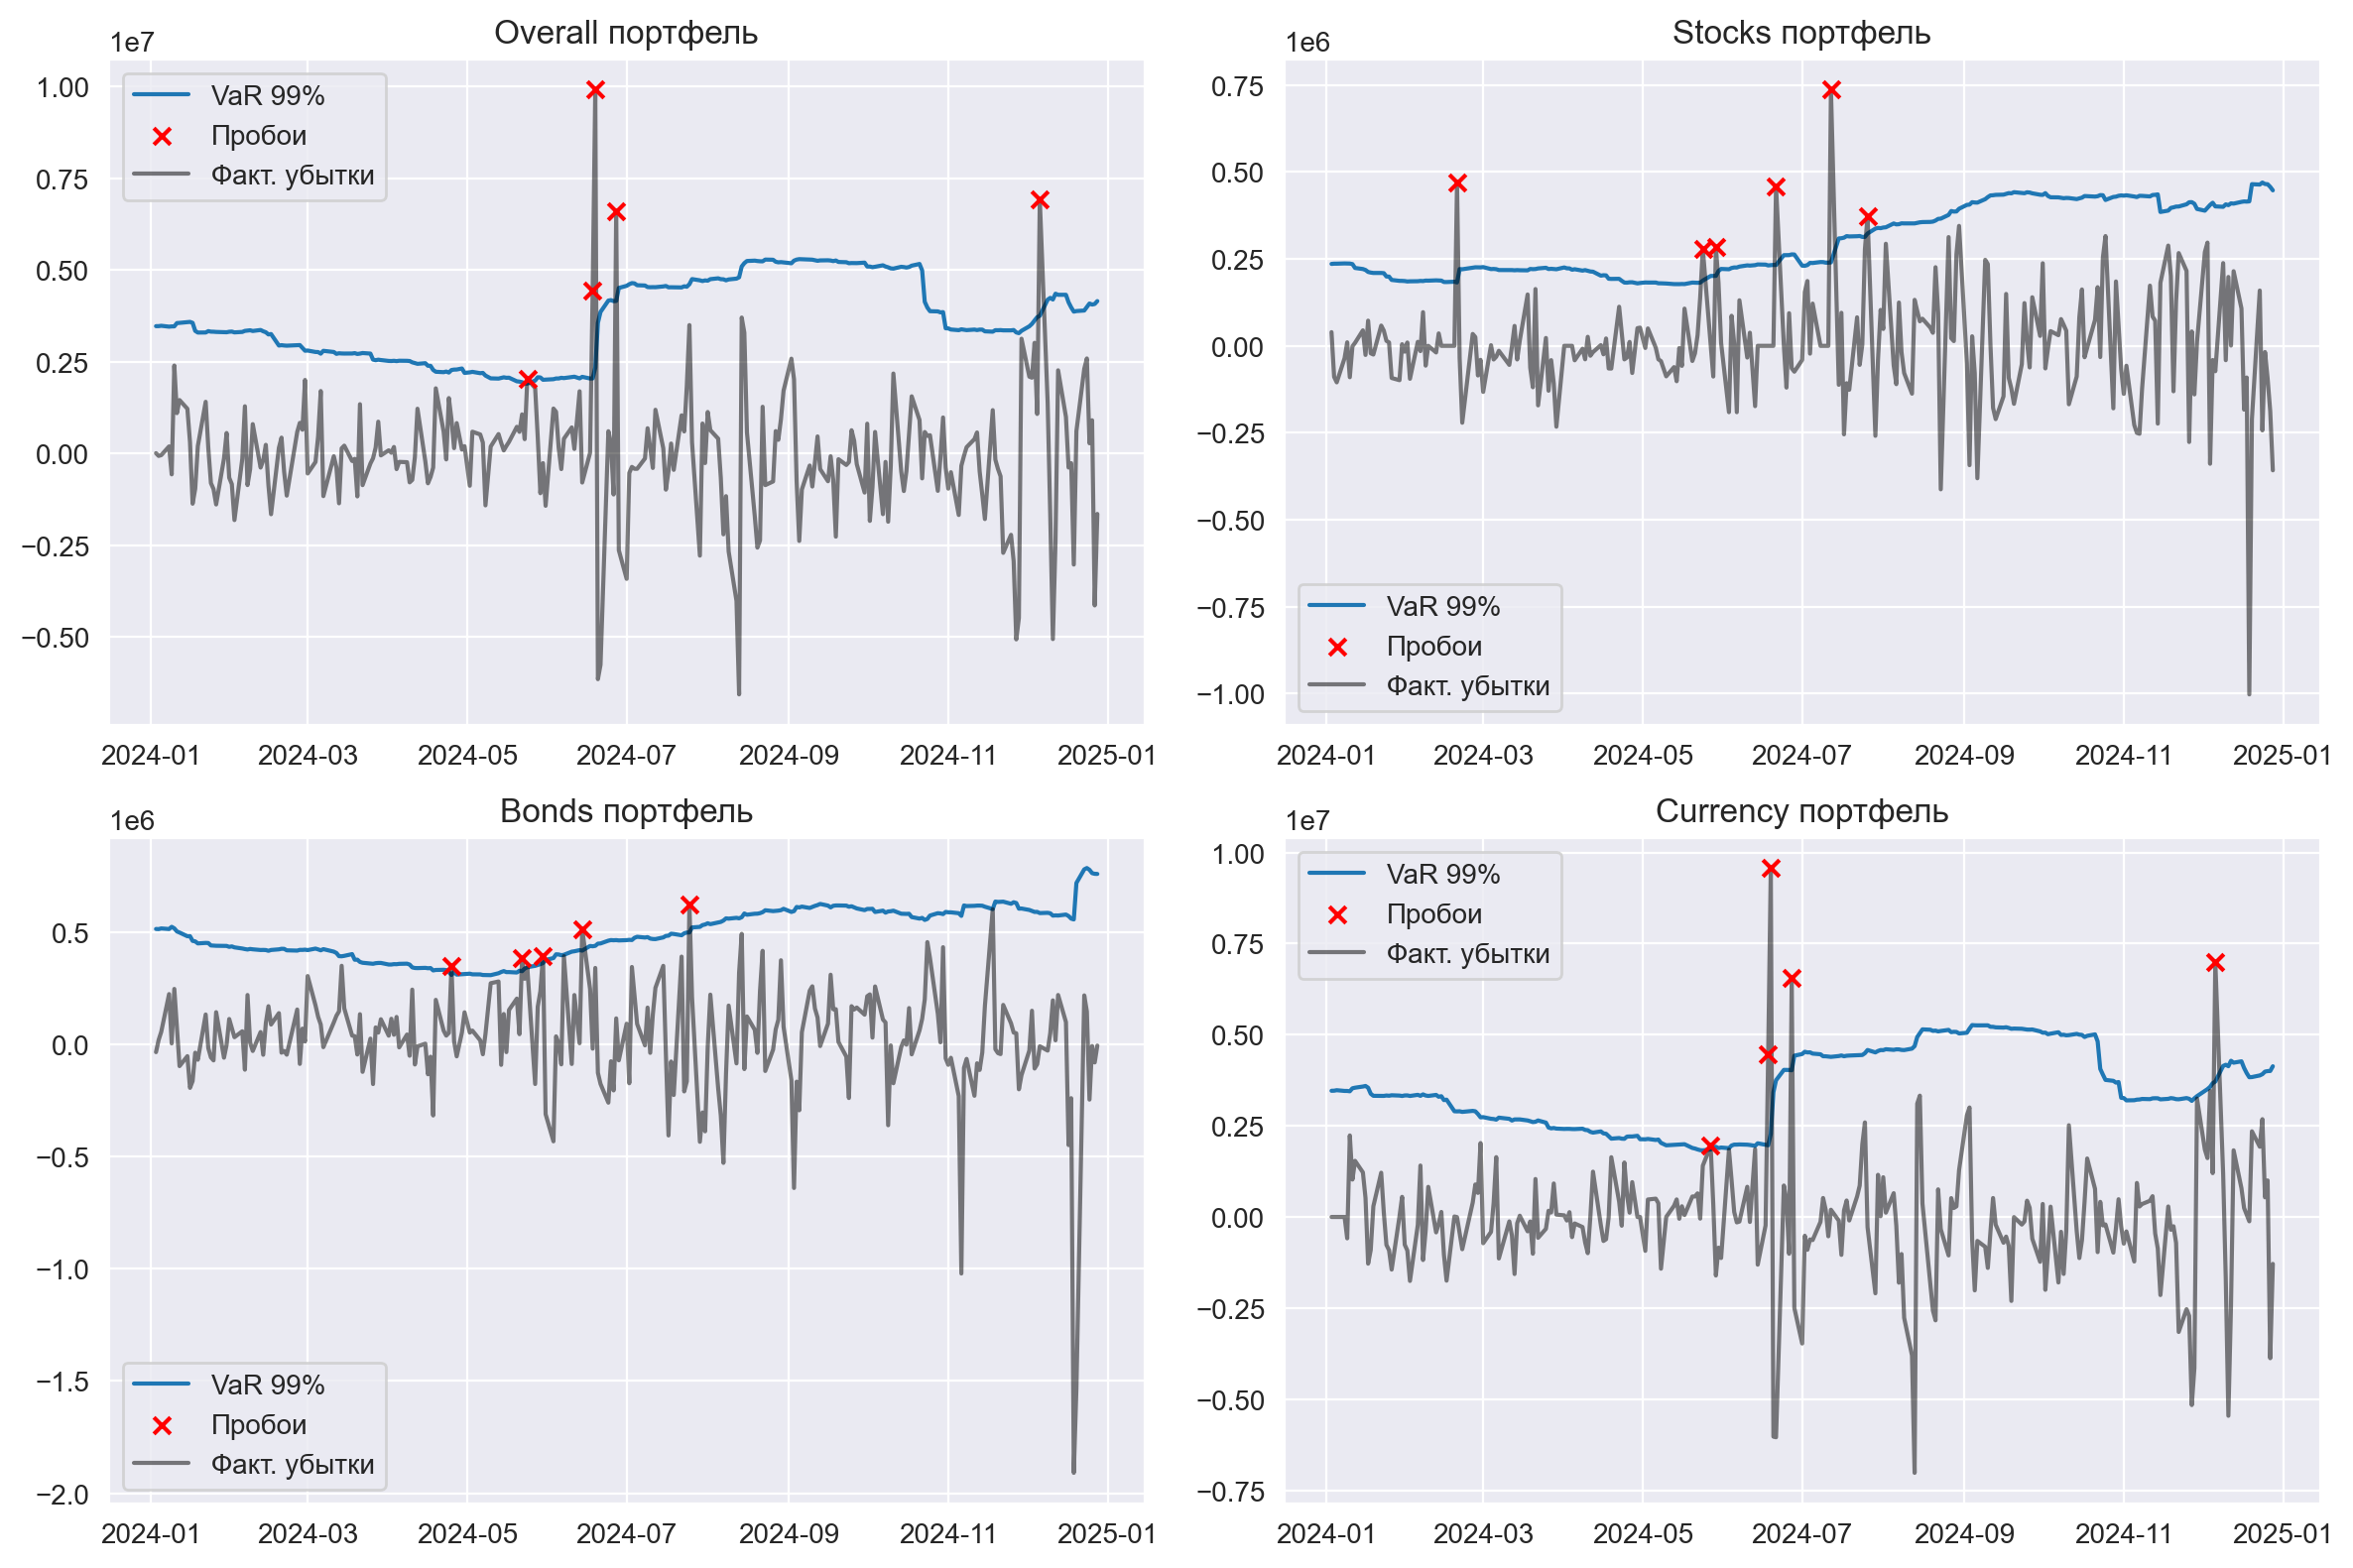

In [51]:
shares_weights = {stock: 1e6 for stock in market_set}
bonds_weights = {bond: 10e6 for bond in debt_set}
currency_weights = {curr: 100e6 for curr in currency_set}

results = {
    'overall': {'date': [], 'var_99': [], 'es_97_5': [], 'actual_loss': [], 'simulated_losses': []},
    'stocks': {'date': [], 'var_99': [], 'es_97_5': [], 'actual_loss': [], 'simulated_losses': []},
    'bonds': {'date': [], 'var_99': [], 'es_97_5': [], 'actual_loss': [], 'simulated_losses': []},
    'currency': {'date': [], 'var_99': [], 'es_97_5': [], 'actual_loss': [], 'simulated_losses': []}
}

for i, date in enumerate(pd.date_range('2024-01-01', '2024-12-31')):
    if date not in data['begin'].values:
        continue
    
    idx = data.index[data['begin'] == date][0]
    if idx + 1 >= len(data):
        continue
    
    history_data = data[data['begin'] <= date]
    current_risk_factors = risk_factors[risk_factors['begin'] <= date][factor_cols]
    
    log_returns = np.log(current_risk_factors / current_risk_factors.shift(1)).dropna()
    mu = log_returns.mean() * 252
    sigma = log_returns.std() * np.sqrt(252)
    corr_matrix = log_returns.corr(method='spearman')
    
    current_prices = data.iloc[idx][market_set + debt_set + currency_set]
    
    positions = {
        **{stock: shares_weights[stock] / current_prices[stock] for stock in market_set},
        **{bond: bonds_weights[bond] / current_prices[bond] for bond in debt_set},
        **{curr: currency_weights[curr] / current_prices[curr] for curr in currency_set}
    }
    
    window_size = 90 
    asset_columns = market_set + debt_set + currency_set
    
    recent_data = history_data.iloc[-window_size:][asset_columns]
    
    asset_returns = np.log(recent_data / recent_data.shift(1)).dropna()
    
    mu_assets = asset_returns.mean().values * 252
    sigma_assets = asset_returns.std().values * np.sqrt(252)
    corr_matrix_assets = asset_returns.corr().values
    
    current_prices_list = current_prices[asset_columns].values
    prices_sim = multi_asset_gbm_simulations(
        S0_list=current_prices_list,
        mu_list=mu_assets,
        sigma_list=sigma_assets,
        corr_matrix=corr_matrix_assets,
        T=1/252, N=1, n_simulations=10000, seed=42
    )
    
    simulated_prices = {}
    for idx_asset, asset in enumerate(asset_columns):
        simulated_prices[asset] = prices_sim[:, idx_asset, 1]
    
    current_values = {}
    for portfolio, assets in zip(
        ['stocks', 'bonds', 'currency', 'overall'],
        [market_set, debt_set, currency_set, market_set + debt_set + currency_set]
    ):
        current_value = sum(positions[asset] * current_prices[asset] for asset in assets)
        current_values[portfolio] = current_value
        
        sim_portfolio_values = np.zeros(10000)
        for asset in assets:
            sim_portfolio_values += positions[asset] * simulated_prices[asset]
        
        sim_losses = current_value - sim_portfolio_values
        
        next_prices = data.iloc[idx+1][assets]
        next_value = sum(positions[asset] * next_prices[asset] for asset in assets)
        actual_loss = current_value - next_value
        
        var_99 = np.percentile(sim_losses, 99)
        tail_losses = sim_losses[sim_losses >= np.percentile(sim_losses, 97.5)]
        es_97_5 = tail_losses.mean()
        
        results[portfolio]['date'].append(date)
        results[portfolio]['var_99'].append(var_99)
        results[portfolio]['es_97_5'].append(es_97_5)
        results[portfolio]['actual_loss'].append(actual_loss)
        results[portfolio]['simulated_losses'].append(sim_losses)

for portfolio in results:
    results[portfolio] = pd.DataFrame(results[portfolio])
    
plt.figure(figsize=(12, 8))
for i, portfolio in enumerate(['overall', 'stocks', 'bonds', 'currency'], 1):
    plt.subplot(2, 2, i)
    df = results[portfolio]
    plt.plot(df['date'], df['var_99'], label='VaR 99%')
    mask = df['actual_loss'] > df['var_99']

    plt.scatter(df['date'][mask], df['actual_loss'][mask],
                color='red', marker='x', label='Пробои', zorder=3)
    plt.plot(df['date'], df['actual_loss'], 'k-', alpha=0.5, label='Факт. убытки')
    plt.title(f"{portfolio.capitalize()} портфель")
    plt.legend()
plt.tight_layout()
plt.show()

In [52]:
quality_report = generate_quality_report(results)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
quality_report

portfolio  alpha                      test  statistic   p_value      conclusion                                            details                                     interpretation
0      bonds   0.99      Christoffersen (Ind)   0.200817  0.654062  Не отвергается                      Тест на независимость пробоев              Пробои независимы (нет кластеризации)
1      bonds   0.99  Christoffersen-Pelletier   2.039095  0.153301  Не отвергается  Тест на распределение длительностей между проб...  Распределение длительностей между пробоями соо...
2      bonds   0.99     Engle-Manganelli (DQ)   5.272401  0.152903  Не отвергается             Тест на правильную спецификацию модели                   Модель правильно специфицирована
3      bonds   0.99               Kupiec (UC)   1.857300  0.172937  Не отвергается                  Пробоев: 5 (1.96%), Ожидаемо: 2.6         Модель правильно оценивает частоту пробоев
4   currency   0.99      Christoffersen (Ind)   3.191197  0.074036  Не отвергается                      Тест на независимость пробоев              Пробои независимы (нет кластеризации)
5   currency   0.99  Christoffersen-Pelletier   1.777485  0.182459  Не отвергается  Тест на распределение длительностей между проб...  Распределение длительностей между пробоями соо...
6   currency   0.99     Engle-Manganelli (DQ)  10.938229  0.012065     Отвергается             Тест на правильную спецификацию модели  Модель неверно специфицирована (пропускает важ...
7   currency   0.99               Kupiec (UC)   1.857300  0.172937  Не отвергается                  Пробоев: 5 (1.96%), Ожидаемо: 2.6         Модель правильно оценивает частоту пробоев
8    overall   0.99      Christoffersen (Ind)   3.191197  0.074036  Не отвергается                      Тест на независимость пробоев              Пробои независимы (нет кластеризации)
9    overall   0.99  Christoffersen-Pelletier   1.726030  0.188919  Не отвергается  Тест на распределение длительностей между проб...  Распределение длительностей между пробоями соо...
10   overall   0.99     Engle-Manganelli (DQ)  10.969135  0.011894     Отвергается             Тест на правильную спецификацию модели  Модель неверно специфицирована (пропускает важ...
11   overall   0.99               Kupiec (UC)   1.857300  0.172937  Не отвергается                  Пробоев: 5 (1.96%), Ожидаемо: 2.6         Модель правильно оценивает частоту пробоев
12    stocks   0.99      Christoffersen (Ind)   0.290351  0.589996  Не отвергается                      Тест на независимость пробоев              Пробои независимы (нет кластеризации)
13    stocks   0.99  Christoffersen-Pelletier   0.030300  0.861811  Не отвергается  Тест на распределение длительностей между проб...  Распределение длительностей между пробоями соо...
14    stocks   0.99     Engle-Manganelli (DQ)   3.614788  0.306177  Не отвергается             Тест на правильную спецификацию модели                   Модель правильно специфицирована
15    stocks   0.99               Kupiec (UC)   3.415358  0.064592  Не отвергается                  Пробоев: 6 (2.35%), Ожидаемо: 2.6         Модель правильно оценивает частоту пробоев

In [53]:
pivot = quality_report.pivot_table(
    index=['test', 'portfolio'], 
    values=['p_value', 'conclusion'],
    aggfunc='first'
)

pivot.columns = [col for col in pivot.columns]

flat_table = pivot.reset_index()
flat_table

test portfolio      conclusion   p_value
0       Christoffersen (Ind)     bonds  Не отвергается  0.654062
1       Christoffersen (Ind)  currency  Не отвергается  0.074036
2       Christoffersen (Ind)   overall  Не отвергается  0.074036
3       Christoffersen (Ind)    stocks  Не отвергается  0.589996
4   Christoffersen-Pelletier     bonds  Не отвергается  0.153301
5   Christoffersen-Pelletier  currency  Не отвергается  0.182459
6   Christoffersen-Pelletier   overall  Не отвергается  0.188919
7   Christoffersen-Pelletier    stocks  Не отвергается  0.861811
8      Engle-Manganelli (DQ)     bonds  Не отвергается  0.152903
9      Engle-Manganelli (DQ)  currency     Отвергается  0.012065
10     Engle-Manganelli (DQ)   overall     Отвергается  0.011894
11     Engle-Manganelli (DQ)    stocks  Не отвергается  0.306177
12               Kupiec (UC)     bonds  Не отвергается  0.172937
13               Kupiec (UC)  currency  Не отвергается  0.172937
14               Kupiec (UC)   overall  Не отвергается  0.172937
15               Kupiec (UC)    stocks  Не отвергается  0.064592

## 10d

100%|██████████| 356/356 [02:07<00:00,  2.79it/s]


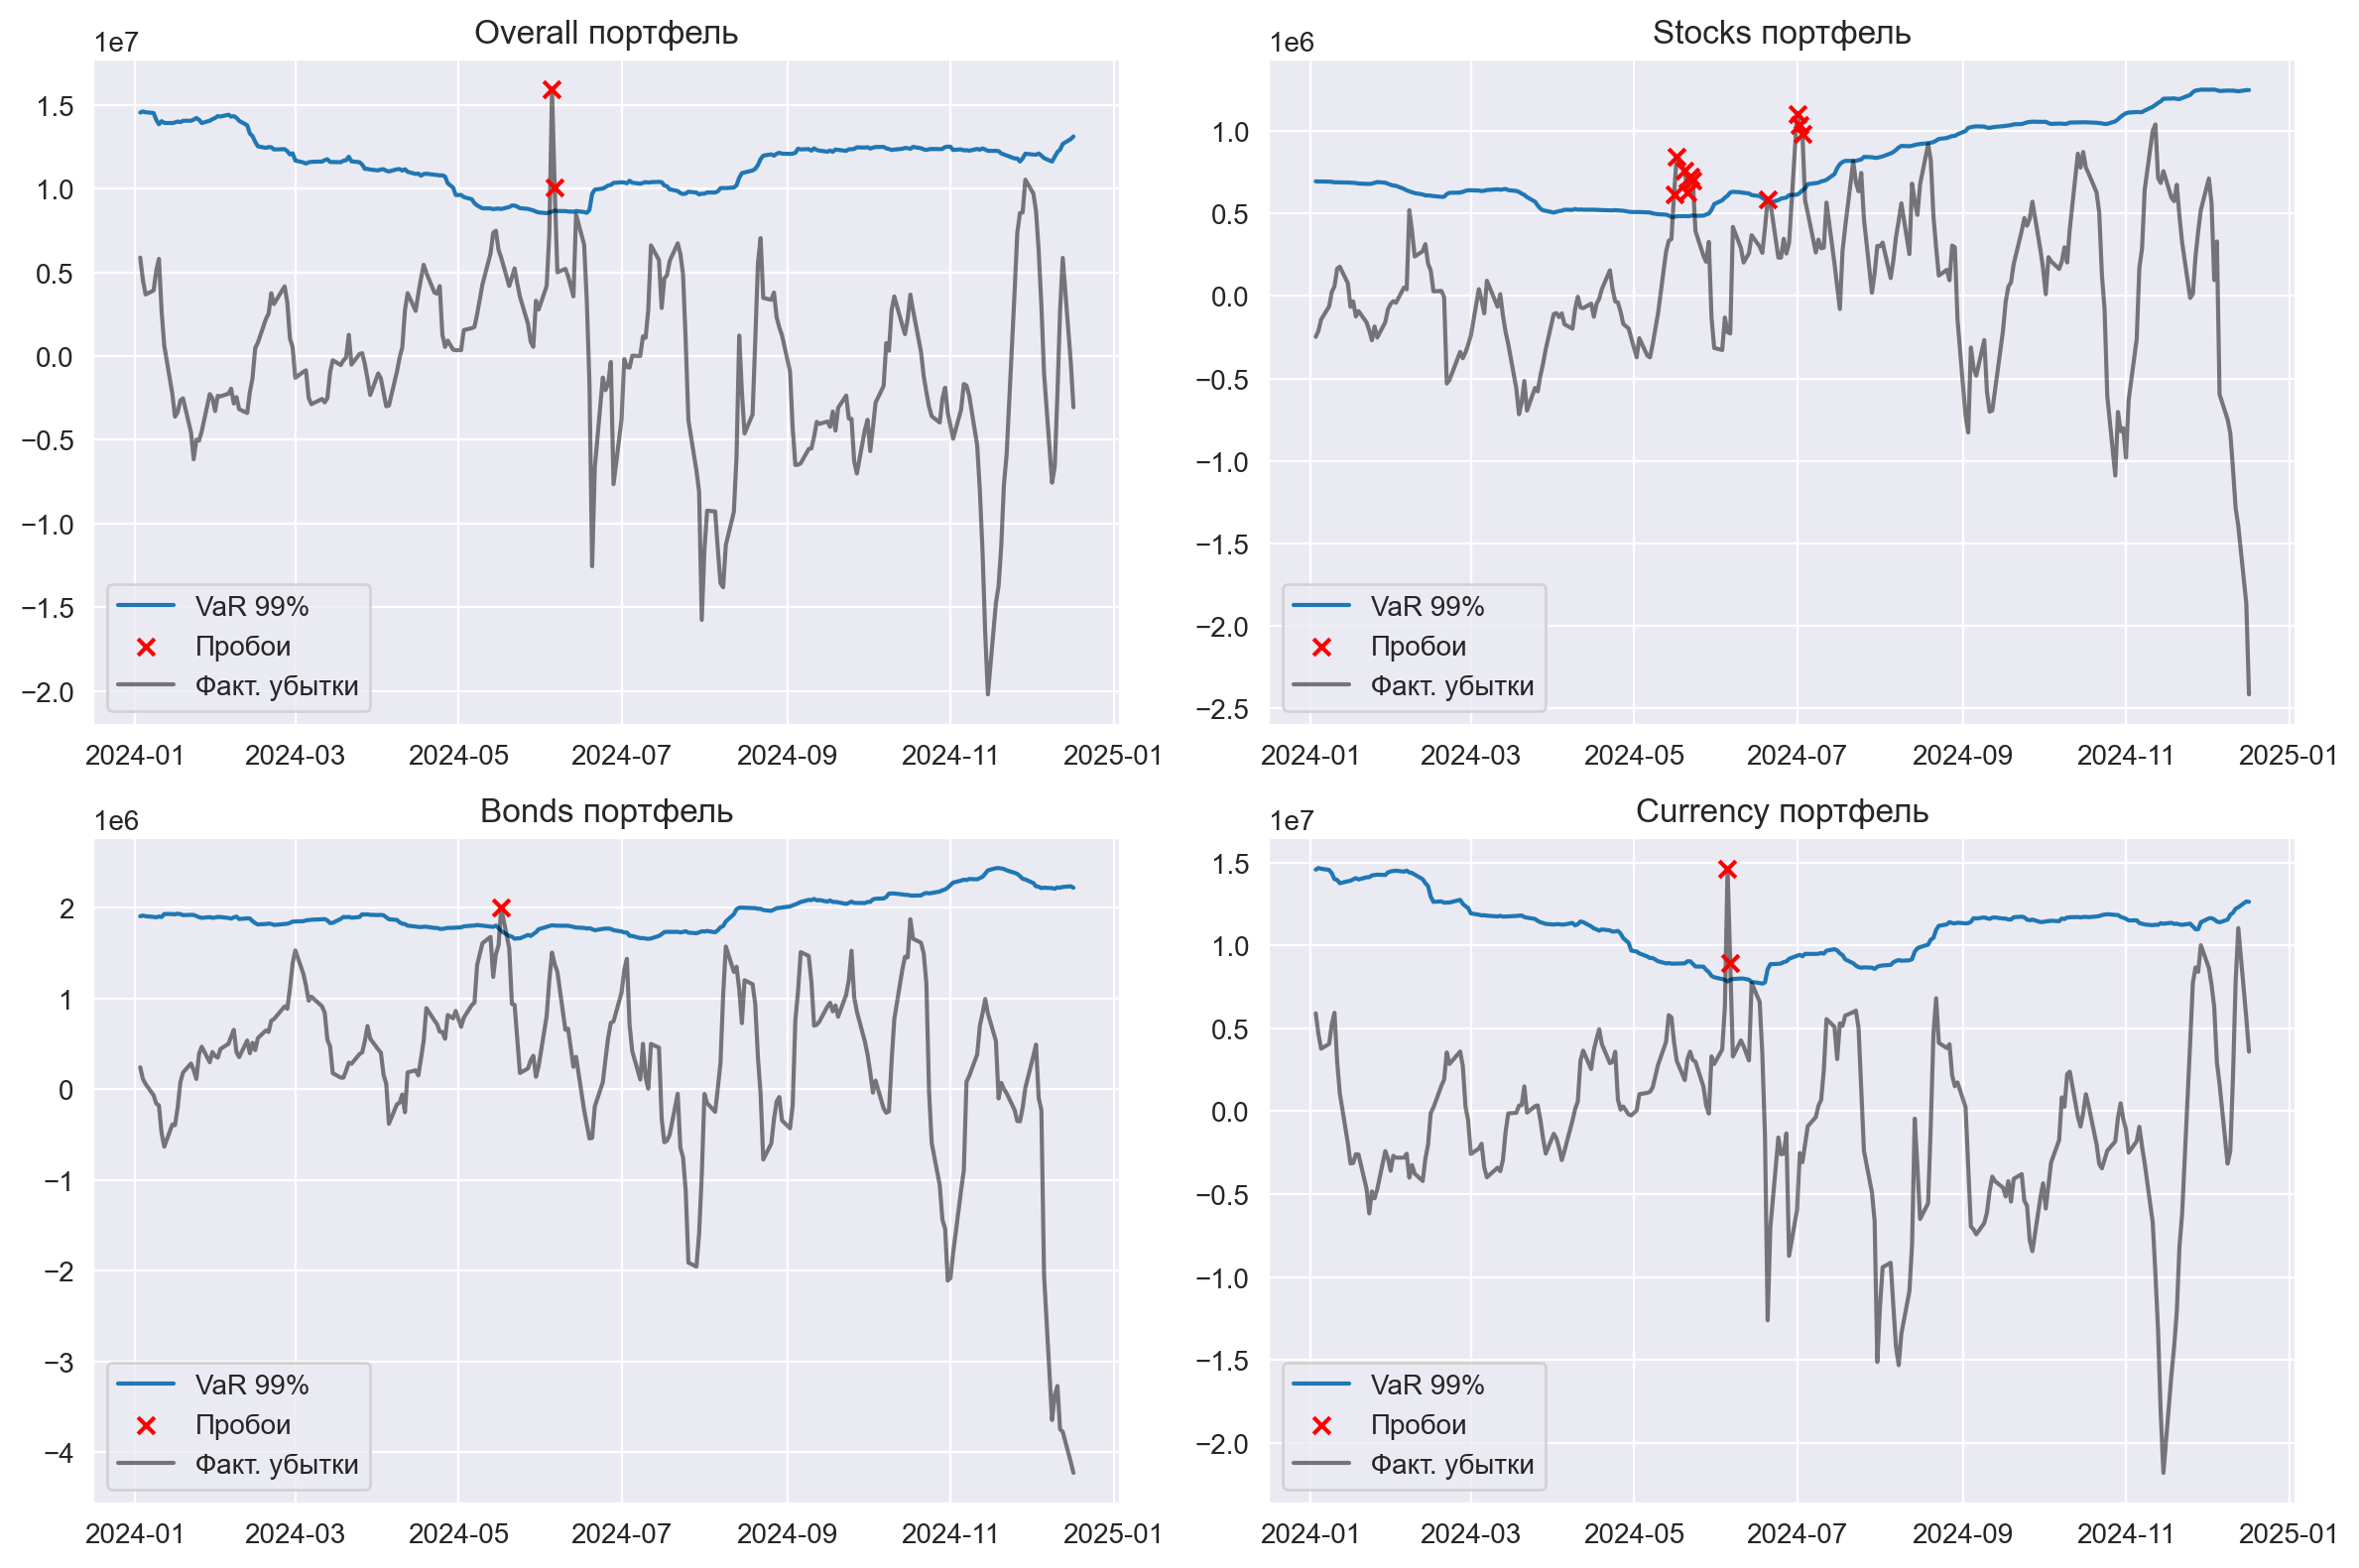

In [41]:
HORIZON_DAYS = 10
ALPHA_VAR = 0.99
ALPHA_ES = 0.975
NSIM = 5000
WINDOW_SIZE = 140

shares_weights = {stock: 1e6 for stock in market_set}
bonds_weights = {bond: 10e6 for bond in debt_set}
currency_weights = {curr: 100e6 for curr in currency_set}

results_10d = {
    'overall': {'date': [], 'var_99': [], 'es_97_5': [], 'actual_loss': []},
    'stocks': {'date': [], 'var_99': [], 'es_97_5': [], 'actual_loss': []},
    'bonds': {'date': [], 'var_99': [], 'es_97_5': [], 'actual_loss': []},
    'currency': {'date': [], 'var_99': [], 'es_97_5': [], 'actual_loss': []}
}


trade_dates = pd.date_range('2024-01-01', '2024-12-21')

for date in tqdm(trade_dates):
    if date not in data['begin'].values:
        continue
    
    date_str = date.strftime('%Y-%m-%d')
    
    idx = data.index[data['begin'] == date][0]
    if idx + HORIZON_DAYS >= len(data):
        continue
    
    history_data = data[data['begin'] <= date]
    
    current_prices = data.iloc[idx][market_set + debt_set + currency_set]
    
    positions = {
        **{stock: shares_weights[stock] / current_prices[stock] for stock in market_set},
        **{bond: bonds_weights[bond] / current_prices[bond] for bond in debt_set},
        **{curr: currency_weights[curr] / current_prices[curr] for curr in currency_set}
    }
    
    asset_columns = market_set + debt_set + currency_set
    
    if len(history_data) < WINDOW_SIZE:
        window_data = history_data
    else:
        window_data = history_data.iloc[-WINDOW_SIZE:]
    
    returns_10d = np.log(window_data[asset_columns] / window_data[asset_columns].shift(HORIZON_DAYS)).dropna()
    
    mu_assets = returns_10d.mean().values * (252 / HORIZON_DAYS)  # Годовой дрифт
    sigma_assets = returns_10d.std().values * np.sqrt(252 / HORIZON_DAYS)  # Годовая волатильность
    corr_matrix_assets = returns_10d.corr().values

    current_prices_list = current_prices[asset_columns].values
    prices_sim = multi_asset_gbm_simulations(
        S0_list=current_prices_list,
        mu_list=mu_assets,
        sigma_list=sigma_assets,
        corr_matrix=corr_matrix_assets,
        T=HORIZON_DAYS/252, 
        N=HORIZON_DAYS, 
        n_simulations=NSIM, 
        seed=42
    )
    
    simulated_prices = {}
    for i_asset, asset in enumerate(asset_columns):
        simulated_prices[asset] = prices_sim[:, i_asset, -1]
    
    for portfolio, assets in zip(
        ['stocks', 'bonds', 'currency', 'overall'],
        [market_set, debt_set, currency_set, market_set + debt_set + currency_set]
    ):
        current_value = sum(positions[asset] * current_prices[asset] for asset in assets)
        
        sim_portfolio_values = np.zeros(NSIM)
        for asset in assets:
            sim_portfolio_values += positions[asset] * simulated_prices[asset]
        
        sim_losses = current_value - sim_portfolio_values
        
        next_prices = data.iloc[idx + HORIZON_DAYS][assets]
        next_value = sum(positions[asset] * next_prices[asset] for asset in assets)
        actual_loss = current_value - next_value
        
        var_99 = np.percentile(sim_losses, ALPHA_VAR * 100)
        tail_losses = sim_losses[sim_losses >= np.percentile(sim_losses, ALPHA_ES * 100)]
        es_97_5 = tail_losses.mean() if len(tail_losses) > 0 else var_99
        
        results_10d[portfolio]['date'].append(date)
        results_10d[portfolio]['var_99'].append(var_99)
        results_10d[portfolio]['es_97_5'].append(es_97_5)
        results_10d[portfolio]['actual_loss'].append(actual_loss)

for portfolio in results_10d:
    results_10d[portfolio] = pd.DataFrame(results_10d[portfolio])

plt.figure(figsize=(12, 8))
for i, portfolio in enumerate(['overall', 'stocks', 'bonds', 'currency'], 1):
    plt.subplot(2, 2, i)
    df = results_10d[portfolio]
    plt.plot(df['date'], df['var_99'], label='VaR 99%')
    mask = df['actual_loss'] > df['var_99']

    plt.scatter(df['date'][mask], df['actual_loss'][mask],
                color='red', marker='x', label='Пробои', zorder=3)
    plt.plot(df['date'], df['actual_loss'], 'k-', alpha=0.5, label='Факт. убытки')
    plt.title(f"{portfolio.capitalize()} портфель")
    plt.legend()
plt.tight_layout()
plt.show()

In [47]:
quality_report = generate_quality_report(results_10d)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
quality_report

portfolio  alpha                      test   statistic       p_value      conclusion                                            details                                     interpretation
0      bonds   0.99      Christoffersen (Ind)    0.008197  9.278614e-01  Не отвергается                      Тест на независимость пробоев              Пробои независимы (нет кластеризации)
1      bonds   0.99  Christoffersen-Pelletier         NaN           NaN      Неприменим      Недостаточно пробоев для теста (требуется ≥2)  Недостаточно данных для проведения теста (треб...
2      bonds   0.99     Engle-Manganelli (DQ)    1.038004  7.920573e-01  Не отвергается             Тест на правильную спецификацию модели                   Модель правильно специфицирована
3      bonds   0.99               Kupiec (UC)    1.128412  2.881142e-01  Не отвергается                  Пробоев: 1 (0.41%), Ожидаемо: 2.5         Модель правильно оценивает частоту пробоев
4   currency   0.99      Christoffersen (Ind)    7.461482  6.303308e-03     Отвергается                      Тест на независимость пробоев  Обнаружена кластеризация пробоев (риск не расп...
5   currency   0.99  Christoffersen-Pelletier   18.511746  1.688605e-05     Отвергается  Тест на распределение длительностей между проб...  Обнаружена кластеризация или анти-кластеризаци...
6   currency   0.99     Engle-Manganelli (DQ)   62.065426  2.127187e-13     Отвергается             Тест на правильную спецификацию модели  Модель неверно специфицирована (пропускает важ...
7   currency   0.99               Kupiec (UC)    0.092812  7.606327e-01  Не отвергается                  Пробоев: 2 (0.81%), Ожидаемо: 2.5         Модель правильно оценивает частоту пробоев
8    overall   0.99      Christoffersen (Ind)    7.461482  6.303308e-03     Отвергается                      Тест на независимость пробоев  Обнаружена кластеризация пробоев (риск не расп...
9    overall   0.99  Christoffersen-Pelletier   18.511746  1.688605e-05     Отвергается  Тест на распределение длительностей между проб...  Обнаружена кластеризация или анти-кластеризаци...
10   overall   0.99     Engle-Manganelli (DQ)   61.941400  2.261524e-13     Отвергается             Тест на правильную спецификацию модели  Модель неверно специфицирована (пропускает важ...
11   overall   0.99               Kupiec (UC)    0.092812  7.606327e-01  Не отвергается                  Пробоев: 2 (0.81%), Ожидаемо: 2.5         Модель правильно оценивает частоту пробоев
12    stocks   0.99      Christoffersen (Ind)   39.214966  3.796192e-10     Отвергается                      Тест на независимость пробоев  Обнаружена кластеризация пробоев (риск не расп...
13    stocks   0.99  Christoffersen-Pelletier    1.092705  2.958725e-01  Не отвергается  Тест на распределение длительностей между проб...  Распределение длительностей между пробоями соо...
14    stocks   0.99     Engle-Manganelli (DQ)  116.998508  0.000000e+00     Отвергается             Тест на правильную спецификацию модели  Модель неверно специфицирована (пропускает важ...
15    stocks   0.99               Kupiec (UC)   13.204360  2.792985e-04     Отвергается                 Пробоев: 10 (4.07%), Ожидаемо: 2.5  Модель неверно оценивает частоту пробоев (слиш...

In [50]:
pivot = quality_report.pivot_table(
    index=['test', 'portfolio'], 
    values=['p_value', 'conclusion'],
    aggfunc='first'
)

pivot.columns = [col for col in pivot.columns]

flat_table = pivot.reset_index()
flat_table

test portfolio      conclusion       p_value
0       Christoffersen (Ind)     bonds  Не отвергается  9.278614e-01
1       Christoffersen (Ind)  currency     Отвергается  6.303308e-03
2       Christoffersen (Ind)   overall     Отвергается  6.303308e-03
3       Christoffersen (Ind)    stocks     Отвергается  3.796192e-10
4   Christoffersen-Pelletier     bonds      Неприменим           NaN
5   Christoffersen-Pelletier  currency     Отвергается  1.688605e-05
6   Christoffersen-Pelletier   overall     Отвергается  1.688605e-05
7   Christoffersen-Pelletier    stocks  Не отвергается  2.958725e-01
8      Engle-Manganelli (DQ)     bonds  Не отвергается  7.920573e-01
9      Engle-Manganelli (DQ)  currency     Отвергается  2.127187e-13
10     Engle-Manganelli (DQ)   overall     Отвергается  2.261524e-13
11     Engle-Manganelli (DQ)    stocks     Отвергается  0.000000e+00
12               Kupiec (UC)     bonds  Не отвергается  2.881142e-01
13               Kupiec (UC)  currency  Не отвергается  7.606327e-01
14               Kupiec (UC)   overall  Не отвергается  7.606327e-01
15               Kupiec (UC)    stocks     Отвергается  2.792985e-04

# T-GBM

Вносим модификацию в GBM: заменяем нормальное распределение распределением Стьюдента.

## 1d

0it [00:00, ?it/s]

366it [00:37,  9.76it/s]


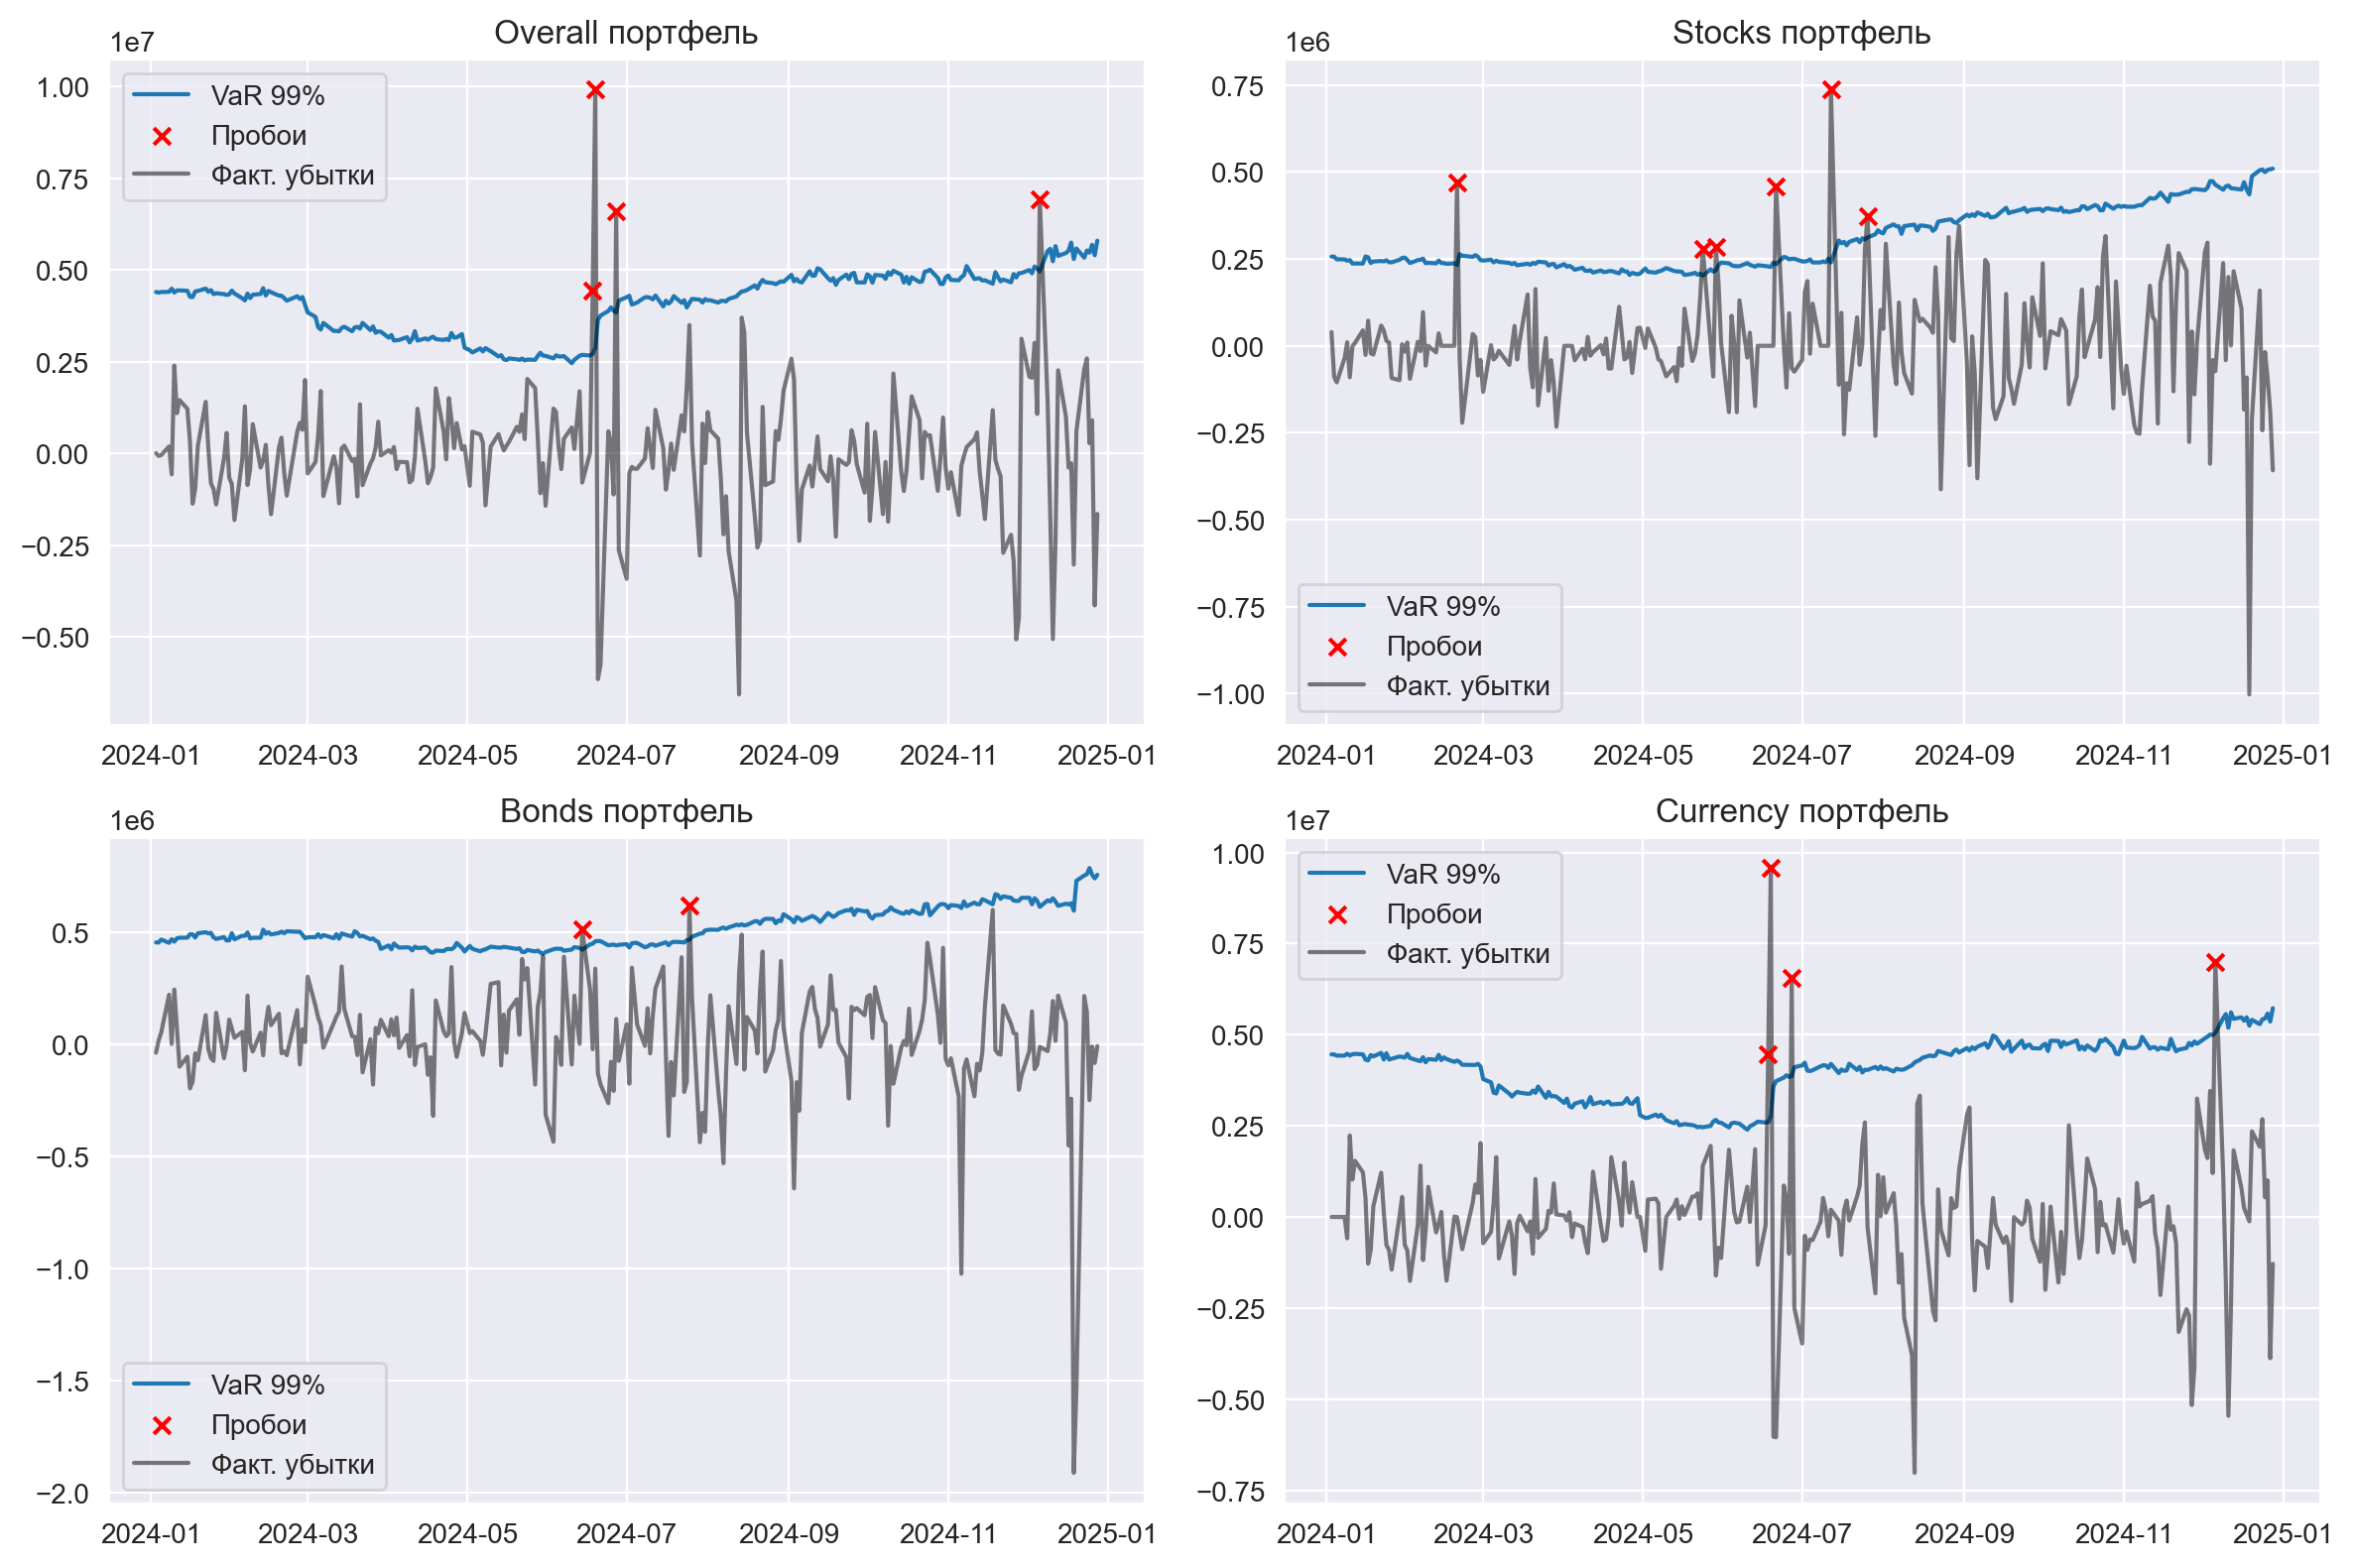

In [54]:
shares_weights = {stock: 1e6 for stock in market_set}
bonds_weights = {bond: 10e6 for bond in debt_set}
currency_weights = {curr: 100e6 for curr in currency_set}

results = {
    'overall': {'date': [], 'var_99': [], 'es_97_5': [], 'actual_loss': []},
    'stocks': {'date': [], 'var_99': [], 'es_97_5': [], 'actual_loss': []},
    'bonds': {'date': [], 'var_99': [], 'es_97_5': [], 'actual_loss': []},
    'currency': {'date': [], 'var_99': [], 'es_97_5': [], 'actual_loss': []}
}

for i, date in tqdm(enumerate(pd.date_range('2024-01-01', '2024-12-31'))):
    if date not in data['begin'].values:
        continue
    
    idx = data.index[data['begin'] == date][0]
    if idx + 1 >= len(data):
        continue
    
    history_data = data[data['begin'] <= date]
    current_risk_factors = risk_factors[risk_factors['begin'] <= date][factor_cols]
    
    log_returns = np.log(current_risk_factors / current_risk_factors.shift(1)).dropna()
    mu = log_returns.mean() * 252
    sigma = log_returns.std() * np.sqrt(252)
    corr_matrix = log_returns.corr(method='spearman')
    
    current_prices = data.iloc[idx][market_set + debt_set + currency_set]
    
    positions = {
        **{stock: shares_weights[stock] / current_prices[stock] for stock in market_set},
        **{bond: bonds_weights[bond] / current_prices[bond] for bond in debt_set},
        **{curr: currency_weights[curr] / current_prices[curr] for curr in currency_set}
    }
    
    window_size = 140
    asset_columns = market_set + debt_set + currency_set
    
    recent_data = history_data.iloc[-window_size:][asset_columns]
    
    asset_returns = np.log(recent_data / recent_data.shift(1)).dropna()
    df_values = []
    for asset in asset_columns:
        returns = asset_returns[asset].dropna()
        if len(returns) > 30:
            kurt = returns.kurtosis()
            df = max(6 - kurt, 3) 
            df_values.append(df)
        else:
            df_values.append(4)  

    df_mean = np.mean(df_values)
    mu_assets = asset_returns.mean().values * 252
    sigma_assets = asset_returns.std().values * np.sqrt(252)
    corr_matrix_assets = asset_returns.corr().values
    
    current_prices_list = current_prices[asset_columns].values
    prices_sim = multi_asset_gbm_t_simulations(
        S0_list=current_prices_list,
        mu_list=mu_assets,
        sigma_list=sigma_assets,
        corr_matrix=corr_matrix_assets,
        T=1/252, N=1, n_simulations=10000, seed=42, df=df_mean
    )
    
    simulated_prices = {}
    for idx_asset, asset in enumerate(asset_columns):
        simulated_prices[asset] = prices_sim[:, idx_asset, 1]
    
    current_values = {}
    for portfolio, assets in zip(
        ['stocks', 'bonds', 'currency', 'overall'],
        [market_set, debt_set, currency_set, market_set + debt_set + currency_set]
    ):
        current_value = sum(positions[asset] * current_prices[asset] for asset in assets)
        current_values[portfolio] = current_value
        
        sim_portfolio_values = np.zeros(10000)
        for asset in assets:
            sim_portfolio_values += positions[asset] * simulated_prices[asset]
        
        sim_losses = current_value - sim_portfolio_values
        
        next_prices = data.iloc[idx+1][assets]
        next_value = sum(positions[asset] * next_prices[asset] for asset in assets)
        actual_loss = current_value - next_value
        
        var_99 = np.percentile(sim_losses, 99)
        tail_losses = sim_losses[sim_losses >= np.percentile(sim_losses, 97.5)]
        es_97_5 = tail_losses.mean()
        
        results[portfolio]['date'].append(date)
        results[portfolio]['var_99'].append(var_99)
        results[portfolio]['es_97_5'].append(es_97_5)
        results[portfolio]['actual_loss'].append(actual_loss)

for portfolio in results:
    results[portfolio] = pd.DataFrame(results[portfolio])
    
plt.figure(figsize=(12, 8))
for i, portfolio in enumerate(['overall', 'stocks', 'bonds', 'currency'], 1):
    plt.subplot(2, 2, i)
    df = results[portfolio]
    plt.plot(df['date'], df['var_99'], label='VaR 99%')
    mask = df['actual_loss'] > df['var_99']

    plt.scatter(df['date'][mask], df['actual_loss'][mask],
                color='red', marker='x', label='Пробои', zorder=3)
    plt.plot(df['date'], df['actual_loss'], 'k-', alpha=0.5, label='Факт. убытки')
    plt.title(f"{portfolio.capitalize()} портфель")
    plt.legend()
plt.tight_layout()
plt.show()


In [55]:
quality_report = generate_quality_report(results)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
quality_report

portfolio  alpha                      test  statistic   p_value      conclusion                                            details                                     interpretation
0      bonds   0.99      Christoffersen (Ind)   0.031746  0.858585  Не отвергается                      Тест на независимость пробоев              Пробои независимы (нет кластеризации)
1      bonds   0.99  Christoffersen-Pelletier        NaN       NaN      Неприменим      Недостаточно пробоев для теста (требуется ≥2)  Недостаточно данных для проведения теста (треб...
2      bonds   0.99     Engle-Manganelli (DQ)   1.575411  0.664978  Не отвергается             Тест на правильную спецификацию модели                   Модель правильно специфицирована
3      bonds   0.99               Kupiec (UC)   0.129413  0.719042  Не отвергается                  Пробоев: 2 (0.78%), Ожидаемо: 2.6         Модель правильно оценивает частоту пробоев
4   currency   0.99      Christoffersen (Ind)   4.145366  0.041749     Отвергается                      Тест на независимость пробоев  Обнаружена кластеризация пробоев (риск не расп...
5   currency   0.99  Christoffersen-Pelletier   2.277747  0.131242  Не отвергается  Тест на распределение длительностей между проб...  Распределение длительностей между пробоями соо...
6   currency   0.99     Engle-Manganelli (DQ)  15.752867  0.001274     Отвергается             Тест на правильную спецификацию модели  Модель неверно специфицирована (пропускает важ...
7   currency   0.99               Kupiec (UC)   0.709952  0.399460  Не отвергается                  Пробоев: 4 (1.57%), Ожидаемо: 2.6         Модель правильно оценивает частоту пробоев
8    overall   0.99      Christoffersen (Ind)   4.145366  0.041749     Отвергается                      Тест на независимость пробоев  Обнаружена кластеризация пробоев (риск не расп...
9    overall   0.99  Christoffersen-Pelletier   2.277747  0.131242  Не отвергается  Тест на распределение длительностей между проб...  Распределение длительностей между пробоями соо...
10   overall   0.99     Engle-Manganelli (DQ)  15.918910  0.001178     Отвергается             Тест на правильную спецификацию модели  Модель неверно специфицирована (пропускает важ...
11   overall   0.99               Kupiec (UC)   0.709952  0.399460  Не отвергается                  Пробоев: 4 (1.57%), Ожидаемо: 2.6         Модель правильно оценивает частоту пробоев
12    stocks   0.99      Christoffersen (Ind)   0.290351  0.589996  Не отвергается                      Тест на независимость пробоев              Пробои независимы (нет кластеризации)
13    stocks   0.99  Christoffersen-Pelletier   0.030300  0.861811  Не отвергается  Тест на распределение длительностей между проб...  Распределение длительностей между пробоями соо...
14    stocks   0.99     Engle-Manganelli (DQ)   4.118044  0.248996  Не отвергается             Тест на правильную спецификацию модели                   Модель правильно специфицирована
15    stocks   0.99               Kupiec (UC)   3.415358  0.064592  Не отвергается                  Пробоев: 6 (2.35%), Ожидаемо: 2.6         Модель правильно оценивает частоту пробоев

In [56]:
pivot = quality_report.pivot_table(
    index=['test', 'portfolio'], 
    values=['p_value', 'conclusion'],
    aggfunc='first'
)

pivot.columns = [col for col in pivot.columns]

flat_table = pivot.reset_index()
flat_table

test portfolio      conclusion   p_value
0       Christoffersen (Ind)     bonds  Не отвергается  0.858585
1       Christoffersen (Ind)  currency     Отвергается  0.041749
2       Christoffersen (Ind)   overall     Отвергается  0.041749
3       Christoffersen (Ind)    stocks  Не отвергается  0.589996
4   Christoffersen-Pelletier     bonds      Неприменим       NaN
5   Christoffersen-Pelletier  currency  Не отвергается  0.131242
6   Christoffersen-Pelletier   overall  Не отвергается  0.131242
7   Christoffersen-Pelletier    stocks  Не отвергается  0.861811
8      Engle-Manganelli (DQ)     bonds  Не отвергается  0.664978
9      Engle-Manganelli (DQ)  currency     Отвергается  0.001274
10     Engle-Manganelli (DQ)   overall     Отвергается  0.001178
11     Engle-Manganelli (DQ)    stocks  Не отвергается  0.248996
12               Kupiec (UC)     bonds  Не отвергается  0.719042
13               Kupiec (UC)  currency  Не отвергается  0.399460
14               Kupiec (UC)   overall  Не отвергается  0.399460
15               Kupiec (UC)    stocks  Не отвергается  0.064592

## 10d

100%|██████████| 356/356 [04:26<00:00,  1.34it/s]


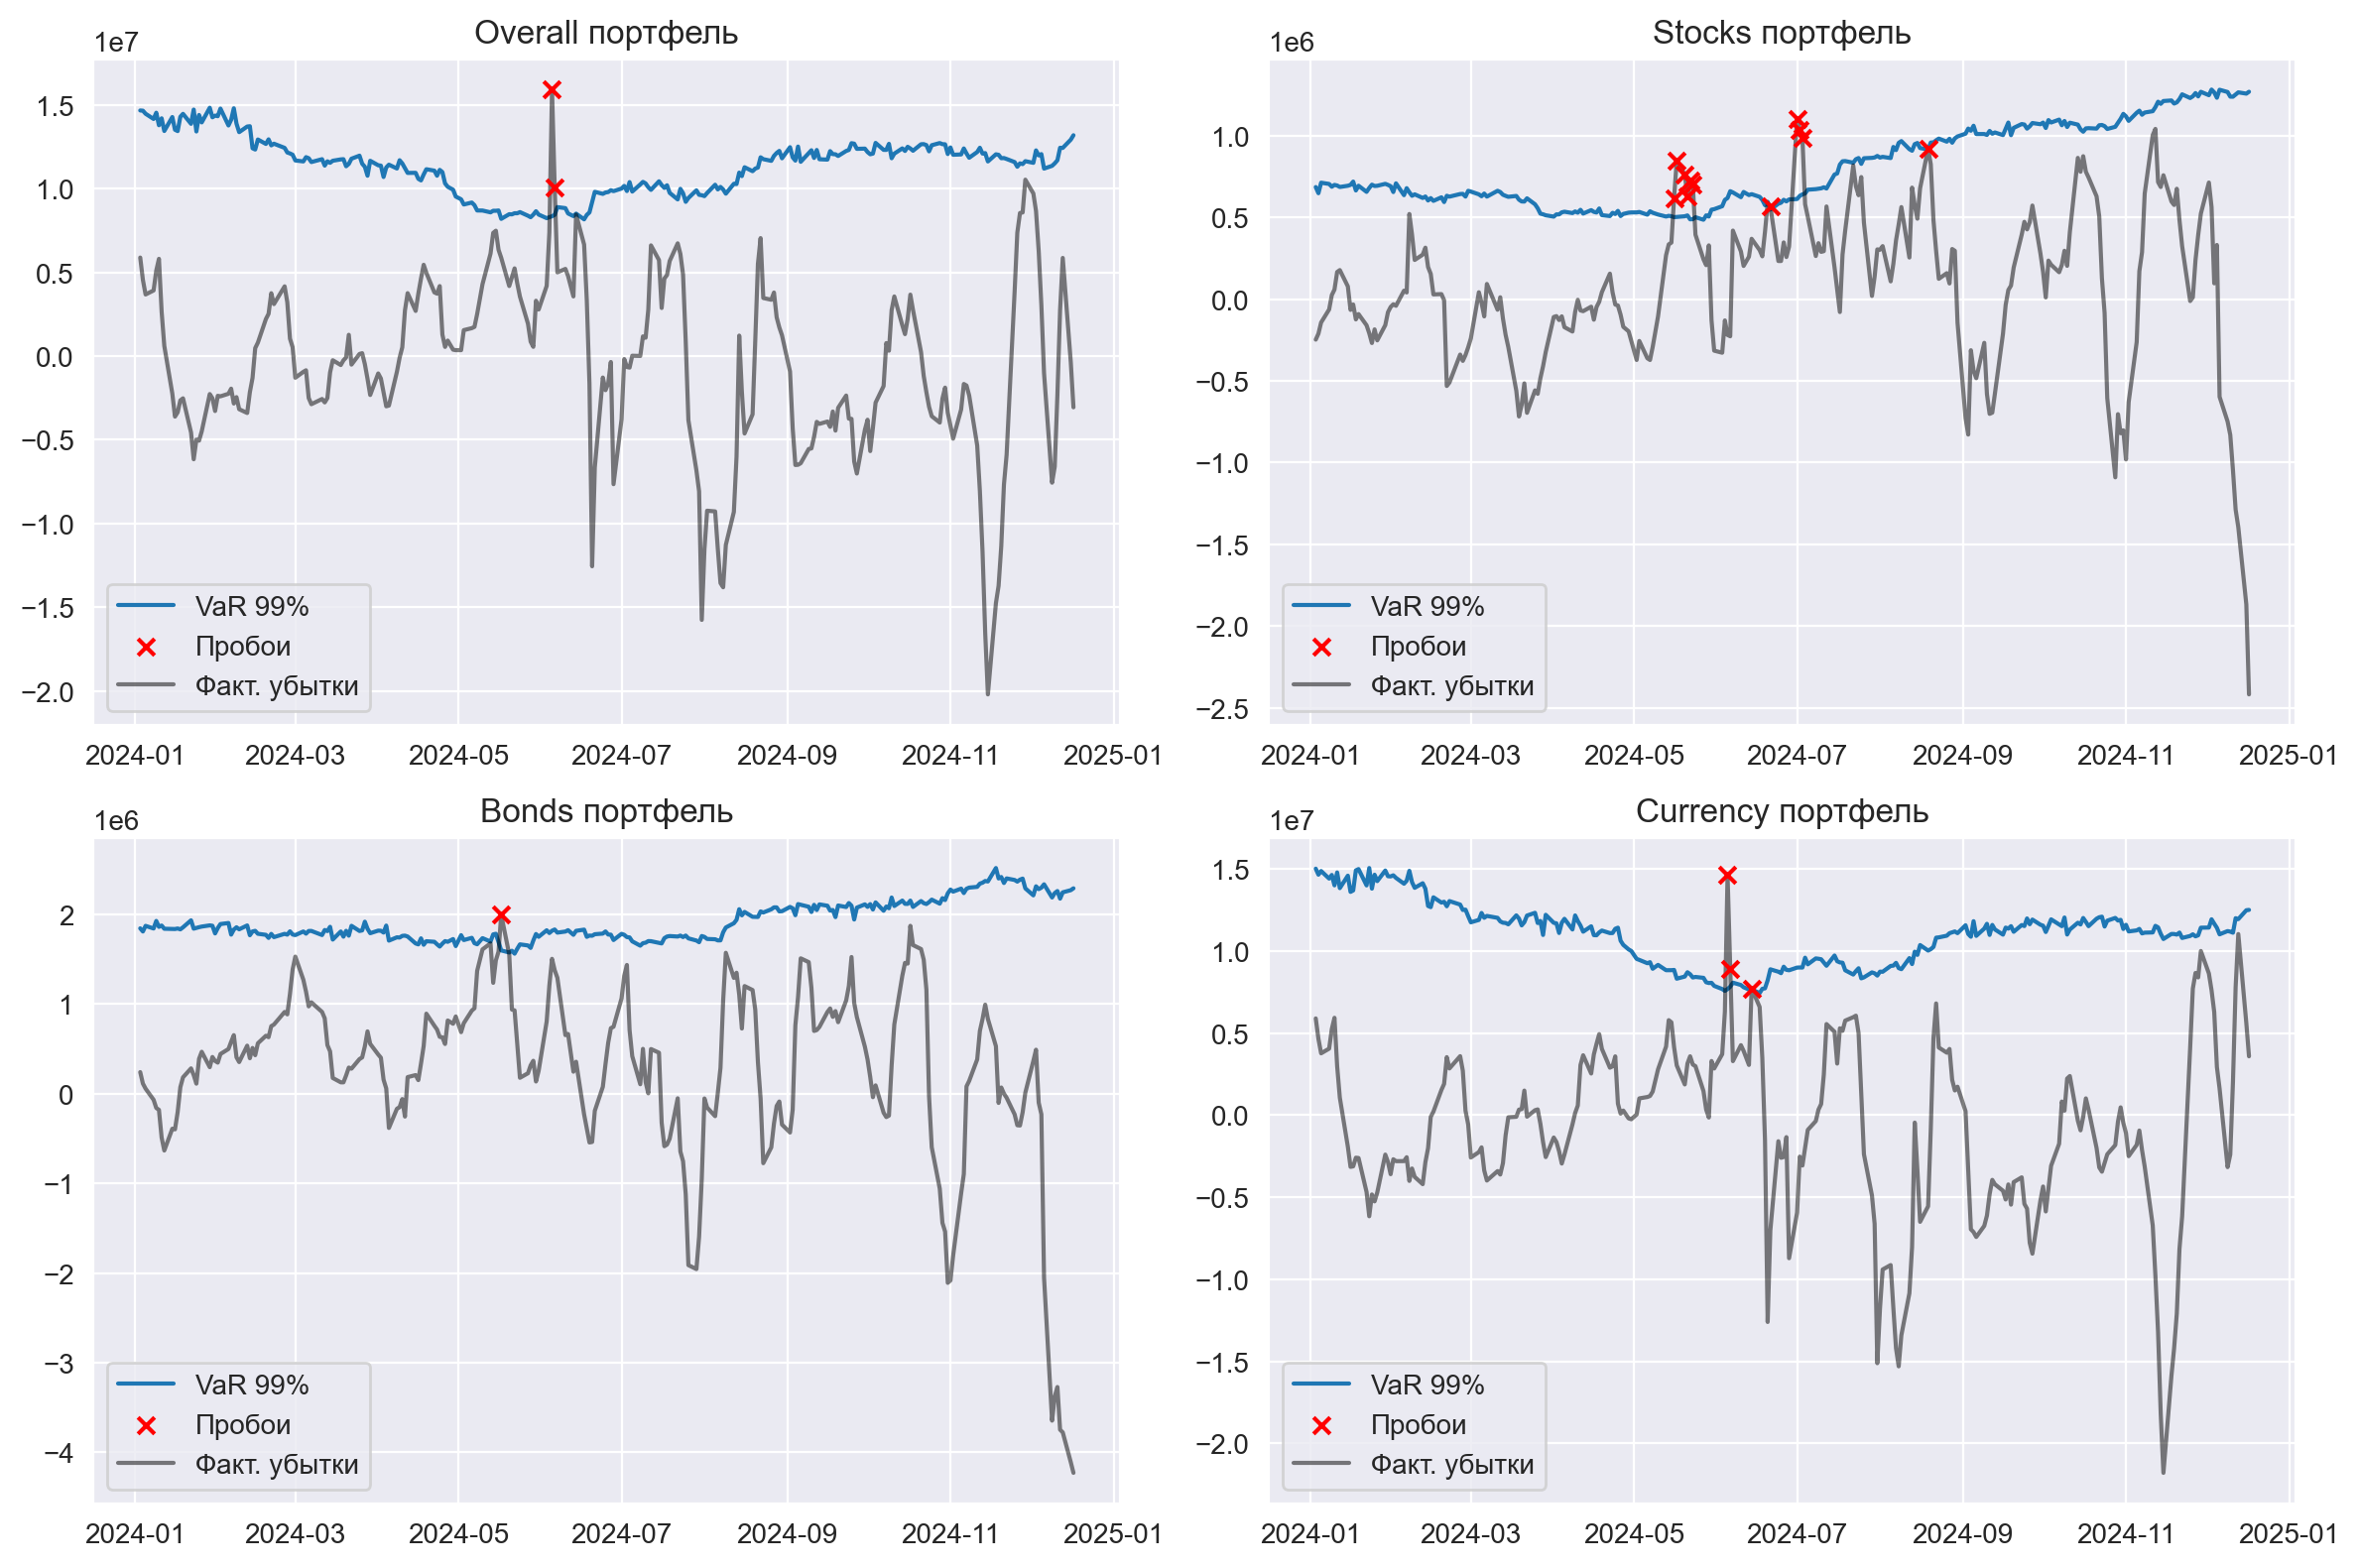

In [57]:
HORIZON_DAYS = 10
ALPHA_VAR = 0.99
ALPHA_ES = 0.975
NSIM = 5000
WINDOW_SIZE = 140 

results_10d = {
    'overall': {'date': [], 'var_99': [], 'es_97_5': [], 'actual_loss': []},
    'stocks': {'date': [], 'var_99': [], 'es_97_5': [], 'actual_loss': []},
    'bonds': {'date': [], 'var_99': [], 'es_97_5': [], 'actual_loss': []},
    'currency': {'date': [], 'var_99': [], 'es_97_5': [], 'actual_loss': []}
}


trade_dates = pd.date_range('2024-01-01', '2024-12-21') 

for date in tqdm(trade_dates):
    if date not in data['begin'].values:
        continue
    
    date_str = date.strftime('%Y-%m-%d')
    
    idx = data.index[data['begin'] == date][0]
    if idx + HORIZON_DAYS >= len(data):
        continue
    
    history_data = data[data['begin'] <= date]
    
    current_prices = data.iloc[idx][market_set + debt_set + currency_set]
    
    positions = {
        **{stock: shares_weights[stock] / current_prices[stock] for stock in market_set},
        **{bond: bonds_weights[bond] / current_prices[bond] for bond in debt_set},
        **{curr: currency_weights[curr] / current_prices[curr] for curr in currency_set}
    }
    
    asset_columns = market_set + debt_set + currency_set
    
    if len(history_data) < WINDOW_SIZE:
        window_data = history_data
    else:
        window_data = history_data.iloc[-WINDOW_SIZE:]
    
    returns_10d = np.log(window_data[asset_columns] / window_data[asset_columns].shift(HORIZON_DAYS)).dropna()
    
    mu_assets = returns_10d.mean().values * (252 / HORIZON_DAYS)  # Годовой дрифт
    sigma_assets = returns_10d.std().values * np.sqrt(252 / HORIZON_DAYS)  # Годовая волатильность
    corr_matrix_assets = returns_10d.corr().values
    
    df_values = []
    for asset in asset_columns:
        returns = returns_10d[asset].dropna()
        if len(returns) > 30:
            kurt = returns.kurtosis()
            df_val = max(6 / kurt + 4 if kurt > 0 else 10, 3)
            df_values.append(df_val)
        else:
            df_values.append(5)  
    
    df_mean = np.mean(df_values)
    
    current_prices_list = current_prices[asset_columns].values
    prices_sim = multi_asset_gbm_t_simulations(
        S0_list=current_prices_list,
        mu_list=mu_assets,
        sigma_list=sigma_assets,
        corr_matrix=corr_matrix_assets,
        df=df_mean,
        T=HORIZON_DAYS/252, 
        N=HORIZON_DAYS, 
        n_simulations=NSIM, 
        seed=42
    )
    
    simulated_prices = {}
    for i_asset, asset in enumerate(asset_columns):
        simulated_prices[asset] = prices_sim[:, i_asset, -1]
    
    for portfolio, assets in zip(
        ['stocks', 'bonds', 'currency', 'overall'],
        [market_set, debt_set, currency_set, market_set + debt_set + currency_set]
    ):
        current_value = sum(positions[asset] * current_prices[asset] for asset in assets)
        
        sim_portfolio_values = np.zeros(NSIM)
        for asset in assets:
            sim_portfolio_values += positions[asset] * simulated_prices[asset]

        sim_losses = current_value - sim_portfolio_values

        next_prices = data.iloc[idx + HORIZON_DAYS][assets]
        next_value = sum(positions[asset] * next_prices[asset] for asset in assets)
        actual_loss = current_value - next_value
        
        var_99 = np.percentile(sim_losses, ALPHA_VAR * 100)
        tail_losses = sim_losses[sim_losses >= np.percentile(sim_losses, ALPHA_ES * 100)]
        es_97_5 = tail_losses.mean() if len(tail_losses) > 0 else var_99
        
        results_10d[portfolio]['date'].append(date)
        results_10d[portfolio]['var_99'].append(var_99)
        results_10d[portfolio]['es_97_5'].append(es_97_5)
        results_10d[portfolio]['actual_loss'].append(actual_loss)

for portfolio in results_10d:
    results_10d[portfolio] = pd.DataFrame(results_10d[portfolio])

plt.figure(figsize=(12, 8))
for i, portfolio in enumerate(['overall', 'stocks', 'bonds', 'currency'], 1):
    plt.subplot(2, 2, i)
    df = results_10d[portfolio]
    plt.plot(df['date'], df['var_99'], label='VaR 99%')
    mask = df['actual_loss'] > df['var_99']

    plt.scatter(df['date'][mask], df['actual_loss'][mask],
                color='red', marker='x', label='Пробои', zorder=3)
    plt.plot(df['date'], df['actual_loss'], 'k-', alpha=0.5, label='Факт. убытки')
    plt.title(f"{portfolio.capitalize()} портфель")
    plt.legend()
plt.tight_layout()
plt.show()

In [58]:
quality_report = generate_quality_report(results_10d)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
quality_report

portfolio  alpha                      test  statistic       p_value      conclusion                                            details                                     interpretation
0      bonds   0.99      Christoffersen (Ind)   0.008197  9.278614e-01  Не отвергается                      Тест на независимость пробоев              Пробои независимы (нет кластеризации)
1      bonds   0.99  Christoffersen-Pelletier        NaN           NaN      Неприменим      Недостаточно пробоев для теста (требуется ≥2)  Недостаточно данных для проведения теста (треб...
2      bonds   0.99     Engle-Manganelli (DQ)   2.231660  5.257393e-01  Не отвергается             Тест на правильную спецификацию модели                   Модель правильно специфицирована
3      bonds   0.99               Kupiec (UC)   1.128412  2.881142e-01  Не отвергается                  Пробоев: 1 (0.41%), Ожидаемо: 2.5         Модель правильно оценивает частоту пробоев
4   currency   0.99      Christoffersen (Ind)   5.393317  2.021401e-02     Отвергается                      Тест на независимость пробоев  Обнаружена кластеризация пробоев (риск не расп...
5   currency   0.99  Christoffersen-Pelletier   0.399153  5.275272e-01  Не отвергается  Тест на распределение длительностей между проб...  Распределение длительностей между пробоями соо...
6   currency   0.99     Engle-Manganelli (DQ)  30.515801  1.074906e-06     Отвергается             Тест на правильную спецификацию модели  Модель неверно специфицирована (пропускает важ...
7   currency   0.99               Kupiec (UC)   0.111904  7.379869e-01  Не отвергается                  Пробоев: 3 (1.22%), Ожидаемо: 2.5         Модель правильно оценивает частоту пробоев
8    overall   0.99      Christoffersen (Ind)   7.461482  6.303308e-03     Отвергается                      Тест на независимость пробоев  Обнаружена кластеризация пробоев (риск не расп...
9    overall   0.99  Christoffersen-Pelletier  18.511746  1.688605e-05     Отвергается  Тест на распределение длительностей между проб...  Обнаружена кластеризация или анти-кластеризаци...
10   overall   0.99     Engle-Manganelli (DQ)  62.282903  1.911804e-13     Отвергается             Тест на правильную спецификацию модели  Модель неверно специфицирована (пропускает важ...
11   overall   0.99               Kupiec (UC)   0.092812  7.606327e-01  Не отвергается                  Пробоев: 2 (0.81%), Ожидаемо: 2.5         Модель правильно оценивает частоту пробоев
12    stocks   0.99      Christoffersen (Ind)  34.868501  3.527416e-09     Отвергается                      Тест на независимость пробоев  Обнаружена кластеризация пробоев (риск не расп...
13    stocks   0.99  Christoffersen-Pelletier   3.550770  5.951781e-02  Не отвергается  Тест на распределение длительностей между проб...  Распределение длительностей между пробоями соо...
14    stocks   0.99     Engle-Manganelli (DQ)  95.677444  0.000000e+00     Отвергается             Тест на правильную спецификацию модели  Модель неверно специфицирована (пропускает важ...
15    stocks   0.99               Kupiec (UC)  16.173174  5.780699e-05     Отвергается                 Пробоев: 11 (4.47%), Ожидаемо: 2.5  Модель неверно оценивает частоту пробоев (слиш...

In [59]:
pivot = quality_report.pivot_table(
    index=['test', 'portfolio'], 
    values=['p_value', 'conclusion'],
    aggfunc='first'
)

pivot.columns = [col for col in pivot.columns]

flat_table = pivot.reset_index()
flat_table

test portfolio      conclusion       p_value
0       Christoffersen (Ind)     bonds  Не отвергается  9.278614e-01
1       Christoffersen (Ind)  currency     Отвергается  2.021401e-02
2       Christoffersen (Ind)   overall     Отвергается  6.303308e-03
3       Christoffersen (Ind)    stocks     Отвергается  3.527416e-09
4   Christoffersen-Pelletier     bonds      Неприменим           NaN
5   Christoffersen-Pelletier  currency  Не отвергается  5.275272e-01
6   Christoffersen-Pelletier   overall     Отвергается  1.688605e-05
7   Christoffersen-Pelletier    stocks  Не отвергается  5.951781e-02
8      Engle-Manganelli (DQ)     bonds  Не отвергается  5.257393e-01
9      Engle-Manganelli (DQ)  currency     Отвергается  1.074906e-06
10     Engle-Manganelli (DQ)   overall     Отвергается  1.911804e-13
11     Engle-Manganelli (DQ)    stocks     Отвергается  0.000000e+00
12               Kupiec (UC)     bonds  Не отвергается  2.881142e-01
13               Kupiec (UC)  currency  Не отвергается  7.379869e-01
14               Kupiec (UC)   overall  Не отвергается  7.606327e-01
15               Kupiec (UC)    stocks     Отвергается  5.780699e-05

# T-GBM with correction

Добавляет корректировку к портфелю акций к прошлой модификации: теперь при наличии пробоя модель будет адаптироваться, поднимая кривую VaR

## 1d

366it [00:56,  6.49it/s]                         


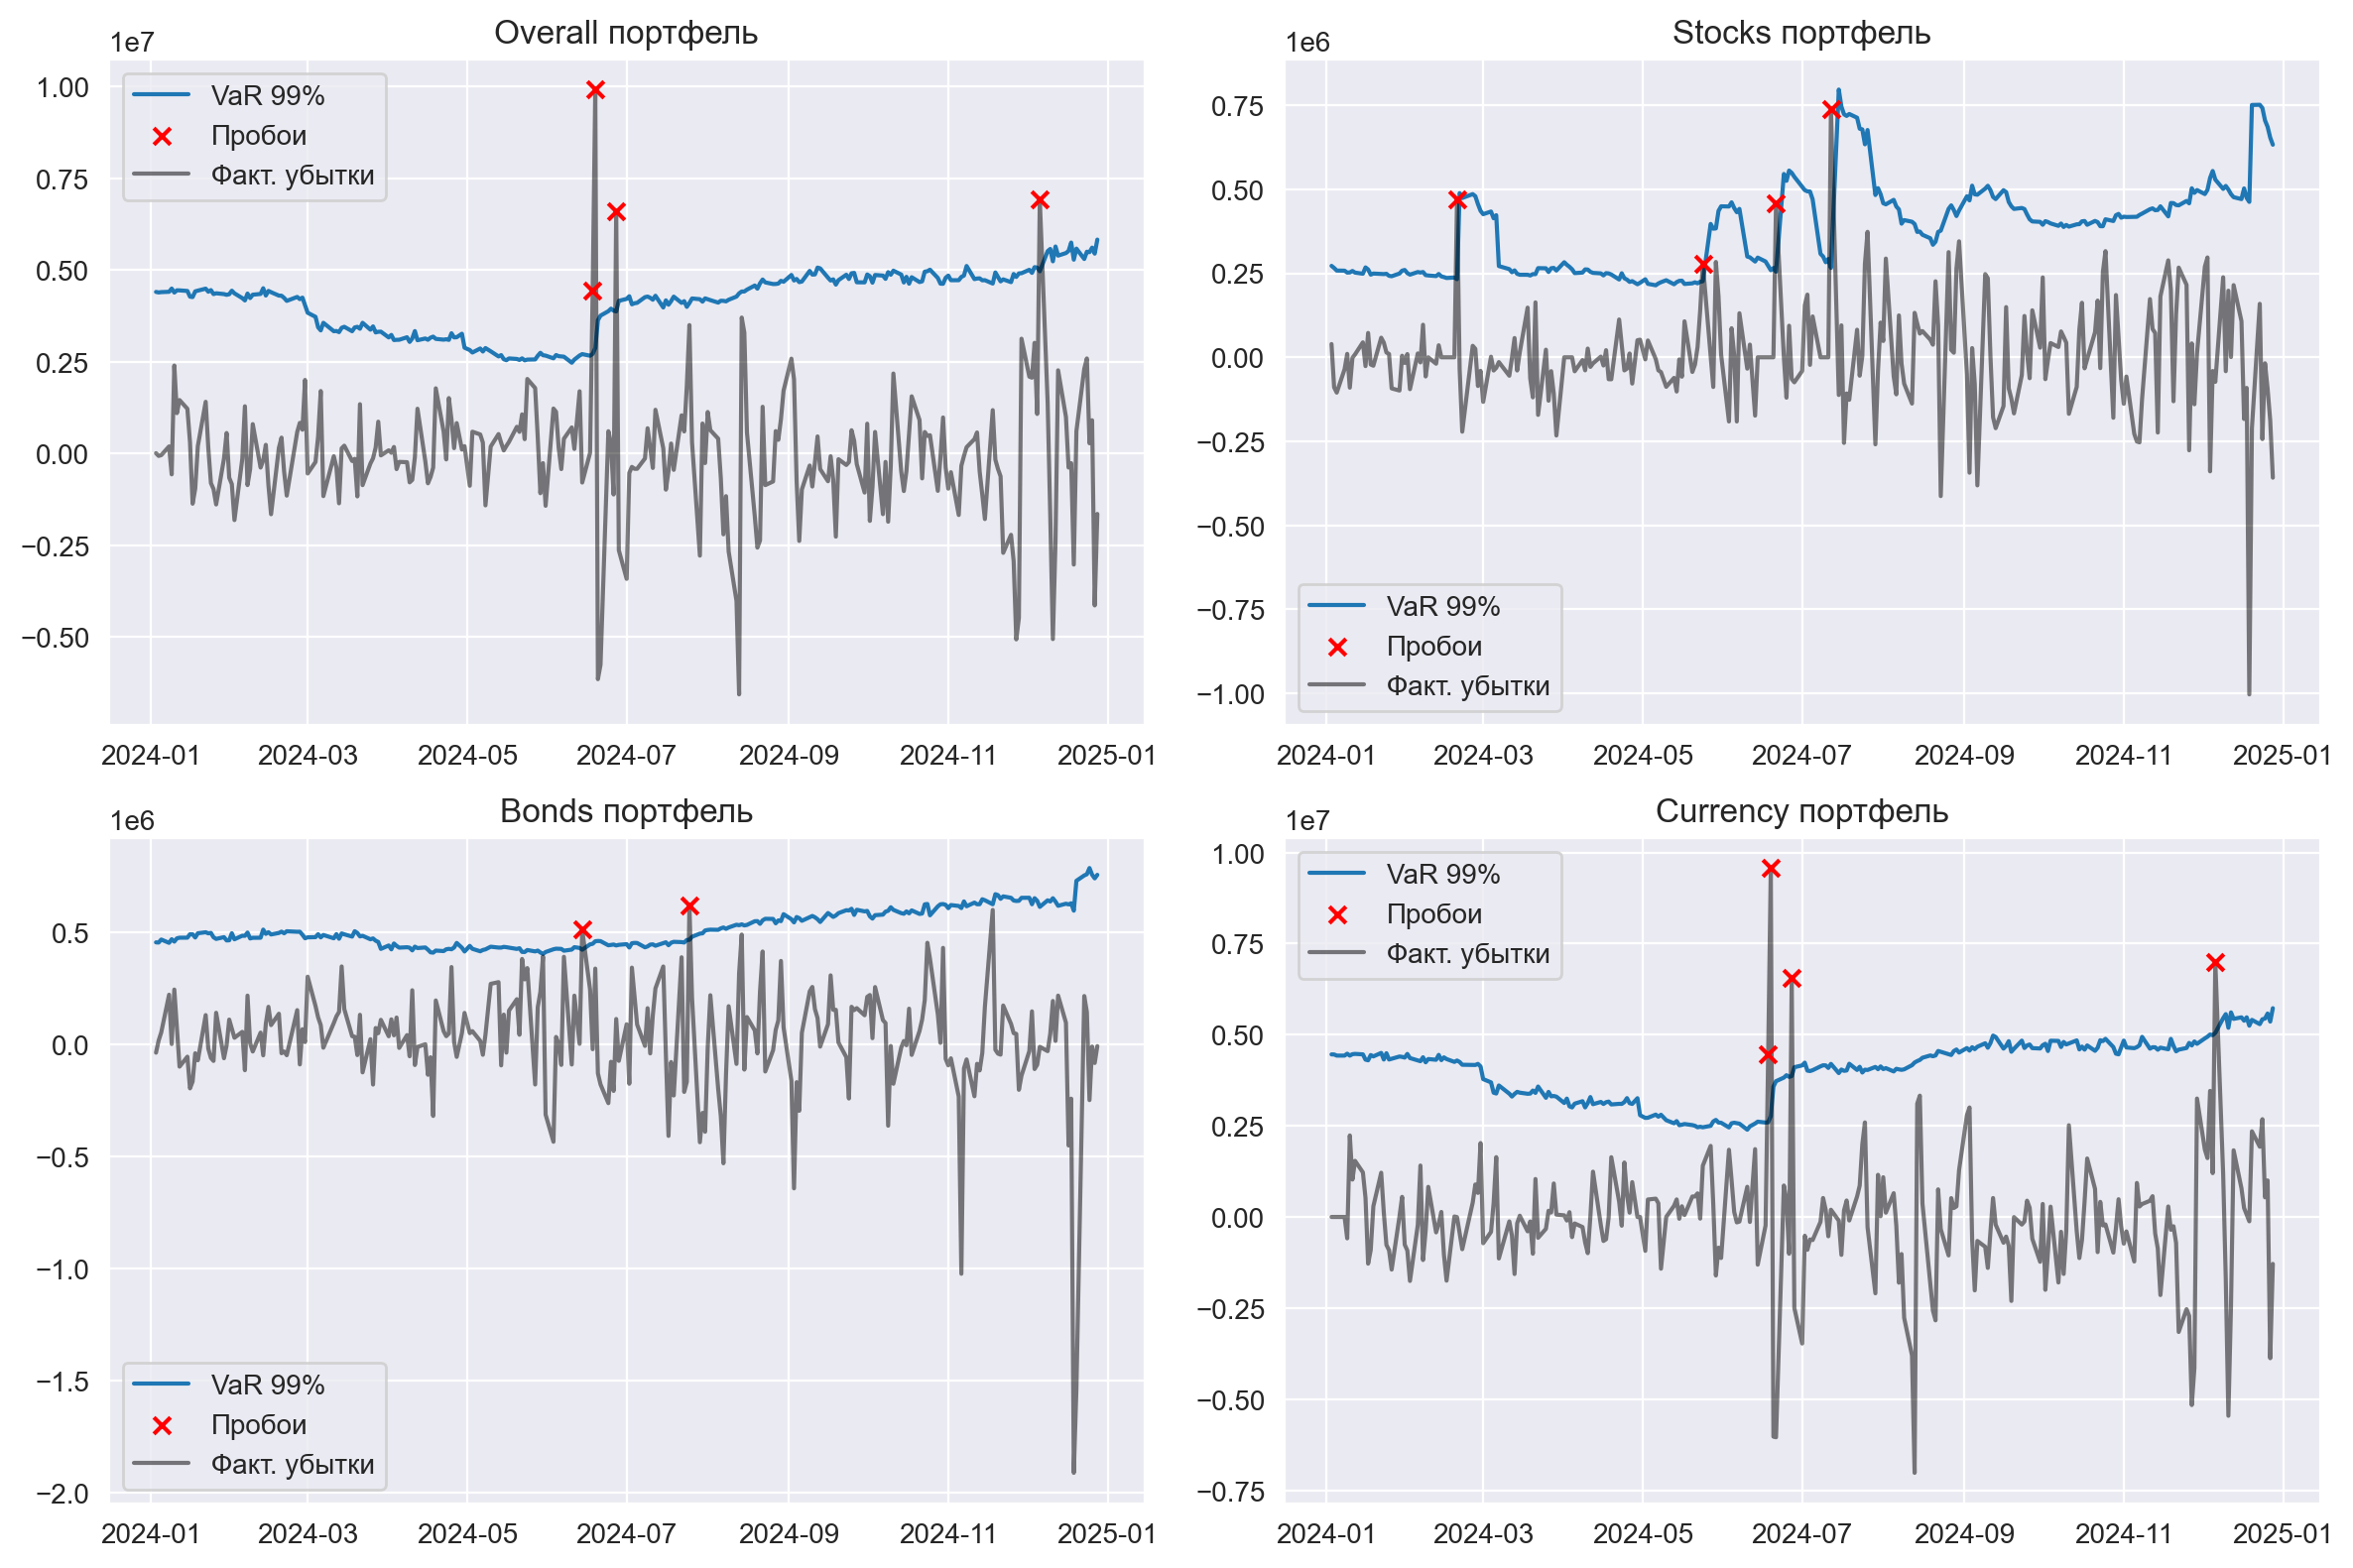

In [60]:
shares_weights = {stock: 1e6 for stock in market_set}
bonds_weights = {bond: 10e6 for bond in debt_set}
currency_weights = {curr: 100e6 for curr in currency_set}

results = {
    'overall': {'date': [], 'var_99': [], 'es_97_5': [], 'actual_loss': []},
    'stocks': {'date': [], 'var_99': [], 'es_97_5': [], 'actual_loss': [], 'correction_factor': []},
    'bonds': {'date': [], 'var_99': [], 'es_97_5': [], 'actual_loss': []},
    'currency': {'date': [], 'var_99': [], 'es_97_5': [], 'actual_loss': []}
}

stock_correction_factors = []
stock_exception_history = []

for i, date in tqdm(enumerate(pd.date_range('2024-01-01', '2024-12-31')), total=252):
    if date not in data['begin'].values:
        continue
    
    idx = data.index[data['begin'] == date][0]
    if idx + 1 >= len(data):
        continue
    
    history_data = data[data['begin'] <= date]
    window_size = 140
    asset_columns = market_set + debt_set + currency_set
    recent_data = history_data.iloc[-window_size:][asset_columns]
    
    asset_returns = np.log(recent_data / recent_data.shift(1)).dropna()
    
    stock_sigma = {}
    for stock in market_set:
        returns = asset_returns[stock].dropna()
        if len(returns) > 10:
            ewma_vol = returns.ewm(alpha=0.10).std().iloc[-1]
            sigma_hist = returns.std()
            stock_sigma[stock] = max(sigma_hist, ewma_vol) * np.sqrt(252)
        else:
            stock_sigma[stock] = asset_returns[stock].std() * np.sqrt(252)
    
    mu_assets = asset_returns.mean() * 252
    sigma_assets = asset_returns.std() * np.sqrt(252)

    for i, asset in enumerate(asset_columns):
        if asset in stock_sigma:
            sigma_assets.iloc[i] = stock_sigma[asset]

    corr_matrix_assets = asset_returns.corr().values

    current_prices = data.iloc[idx][asset_columns]
    positions = {
        **{stock: shares_weights[stock] / current_prices[stock] for stock in market_set},
        **{bond: bonds_weights[bond] / current_prices[bond] for bond in debt_set},
        **{curr: currency_weights[curr] / current_prices[curr] for curr in currency_set}
    }
    
    df_values = []
    for asset in asset_columns:
        returns = asset_returns[asset].dropna()
        if len(returns) > 30:
            kurt = returns.kurtosis()
            df = max(6 - kurt, 3)  
            df_values.append(df)
        else:
            df_values.append(4)
    df_mean = np.mean(df_values)
    current_prices_list = current_prices.values
    prices_sim = multi_asset_gbm_t_simulations(
        S0_list=current_prices_list,
        mu_list=mu_assets.values,
        sigma_list=sigma_assets.values,
        corr_matrix=corr_matrix_assets,
        T=1/252, 
        N=1, 
        n_simulations=10000, 
        seed=42, 
        df=df_mean
    )
    
    simulated_prices = {}
    for idx_asset, asset in enumerate(asset_columns):
        simulated_prices[asset] = prices_sim[:, idx_asset, 1]
    
    for portfolio, assets in zip(
        ['stocks', 'bonds', 'currency', 'overall'],
        [market_set, debt_set, currency_set, market_set + debt_set + currency_set]
    ):
        current_value = sum(positions[asset] * current_prices[asset] for asset in assets)
        sim_portfolio_values = np.zeros(10000)
        for asset in assets:
            sim_portfolio_values += positions[asset] * simulated_prices[asset]
        
        sim_losses = current_value - sim_portfolio_values
        next_value = sum(positions[asset] * data.iloc[idx+1][asset] for asset in assets)
        actual_loss = current_value - next_value
        
        if portfolio == 'stocks':
            var_99 = np.percentile(sim_losses, 99)
            es_97_5 = np.percentile(sim_losses, 99.5) 
            
            if len(stock_exception_history) > 10:
                recent_exceptions = sum(stock_exception_history[-10:])
                expected_exceptions = 0.01 * len(stock_exception_history[-10:])
                
                if recent_exceptions > expected_exceptions:
                    excess_ratio = recent_exceptions / max(expected_exceptions, 0.1)
                    correction_factor = min(1.5, 1 + (excess_ratio - 1) * 0.2)
                    var_99 *= correction_factor
                    results['stocks']['correction_factor'].append(correction_factor)
                else:
                    results['stocks']['correction_factor'].append(1.0)
            else:
                results['stocks']['correction_factor'].append(1.0)
            
            is_exception = 1 if actual_loss > var_99 else 0
            stock_exception_history.append(is_exception)
        else:
            var_99 = np.percentile(sim_losses, 99)
            tail_losses = sim_losses[sim_losses >= np.percentile(sim_losses, 97.5)]
            es_97_5 = tail_losses.mean() if len(tail_losses) > 0 else np.nan

        results[portfolio]['date'].append(date)
        results[portfolio]['var_99'].append(var_99)
        results[portfolio]['es_97_5'].append(es_97_5)
        results[portfolio]['actual_loss'].append(actual_loss)

for portfolio in results:
    results[portfolio] = pd.DataFrame(results[portfolio])

plt.figure(figsize=(12, 8))
for i, portfolio in enumerate(['overall', 'stocks', 'bonds', 'currency'], 1):
    plt.subplot(2, 2, i)
    df = results[portfolio]
    plt.plot(df['date'], df['var_99'], label='VaR 99%')
    mask = df['actual_loss'] > df['var_99']

    plt.scatter(df['date'][mask], df['actual_loss'][mask],
                color='red', marker='x', label='Пробои', zorder=3)
    plt.plot(df['date'], df['actual_loss'], 'k-', alpha=0.5, label='Факт. убытки')
    plt.title(f"{portfolio.capitalize()} портфель")
    plt.legend()
plt.tight_layout()
plt.show()

In [61]:
quality_report = generate_quality_report(results)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
quality_report

portfolio  alpha                      test  statistic   p_value      conclusion                                            details                                     interpretation
0      bonds   0.99      Christoffersen (Ind)   0.031746  0.858585  Не отвергается                      Тест на независимость пробоев              Пробои независимы (нет кластеризации)
1      bonds   0.99  Christoffersen-Pelletier        NaN       NaN      Неприменим      Недостаточно пробоев для теста (требуется ≥2)  Недостаточно данных для проведения теста (треб...
2      bonds   0.99     Engle-Manganelli (DQ)   1.575411  0.664978  Не отвергается             Тест на правильную спецификацию модели                   Модель правильно специфицирована
3      bonds   0.99               Kupiec (UC)   0.129413  0.719042  Не отвергается                  Пробоев: 2 (0.78%), Ожидаемо: 2.6         Модель правильно оценивает частоту пробоев
4   currency   0.99      Christoffersen (Ind)   4.145366  0.041749     Отвергается                      Тест на независимость пробоев  Обнаружена кластеризация пробоев (риск не расп...
5   currency   0.99  Christoffersen-Pelletier   2.277747  0.131242  Не отвергается  Тест на распределение длительностей между проб...  Распределение длительностей между пробоями соо...
6   currency   0.99     Engle-Manganelli (DQ)  15.752867  0.001274     Отвергается             Тест на правильную спецификацию модели  Модель неверно специфицирована (пропускает важ...
7   currency   0.99               Kupiec (UC)   0.709952  0.399460  Не отвергается                  Пробоев: 4 (1.57%), Ожидаемо: 2.6         Модель правильно оценивает частоту пробоев
8    overall   0.99      Christoffersen (Ind)   4.145366  0.041749     Отвергается                      Тест на независимость пробоев  Обнаружена кластеризация пробоев (риск не расп...
9    overall   0.99  Christoffersen-Pelletier   2.277747  0.131242  Не отвергается  Тест на распределение длительностей между проб...  Распределение длительностей между пробоями соо...
10   overall   0.99     Engle-Manganelli (DQ)  15.868447  0.001207     Отвергается             Тест на правильную спецификацию модели  Модель неверно специфицирована (пропускает важ...
11   overall   0.99               Kupiec (UC)   0.709952  0.399460  Не отвергается                  Пробоев: 4 (1.57%), Ожидаемо: 2.6         Модель правильно оценивает частоту пробоев
12    stocks   0.99      Christoffersen (Ind)   0.128005  0.720509  Не отвергается                      Тест на независимость пробоев              Пробои независимы (нет кластеризации)
13    stocks   0.99  Christoffersen-Pelletier   0.842061  0.358808  Не отвергается  Тест на распределение длительностей между проб...  Распределение длительностей между пробоями соо...
14    stocks   0.99     Engle-Manganelli (DQ)   4.476479  0.214398  Не отвергается             Тест на правильную спецификацию модели                   Модель правильно специфицирована
15    stocks   0.99               Kupiec (UC)   0.709952  0.399460  Не отвергается                  Пробоев: 4 (1.57%), Ожидаемо: 2.6         Модель правильно оценивает частоту пробоев

In [62]:
pivot = quality_report.pivot_table(
    index=['test', 'portfolio'], 
    values=['p_value', 'conclusion'],
    aggfunc='first'
)

pivot.columns = [col for col in pivot.columns]

flat_table = pivot.reset_index()
flat_table

test portfolio      conclusion   p_value
0       Christoffersen (Ind)     bonds  Не отвергается  0.858585
1       Christoffersen (Ind)  currency     Отвергается  0.041749
2       Christoffersen (Ind)   overall     Отвергается  0.041749
3       Christoffersen (Ind)    stocks  Не отвергается  0.720509
4   Christoffersen-Pelletier     bonds      Неприменим       NaN
5   Christoffersen-Pelletier  currency  Не отвергается  0.131242
6   Christoffersen-Pelletier   overall  Не отвергается  0.131242
7   Christoffersen-Pelletier    stocks  Не отвергается  0.358808
8      Engle-Manganelli (DQ)     bonds  Не отвергается  0.664978
9      Engle-Manganelli (DQ)  currency     Отвергается  0.001274
10     Engle-Manganelli (DQ)   overall     Отвергается  0.001207
11     Engle-Manganelli (DQ)    stocks  Не отвергается  0.214398
12               Kupiec (UC)     bonds  Не отвергается  0.719042
13               Kupiec (UC)  currency  Не отвергается  0.399460
14               Kupiec (UC)   overall  Не отвергается  0.399460
15               Kupiec (UC)    stocks  Не отвергается  0.399460

## 10d

100%|██████████| 350/350 [03:18<00:00,  1.76it/s]


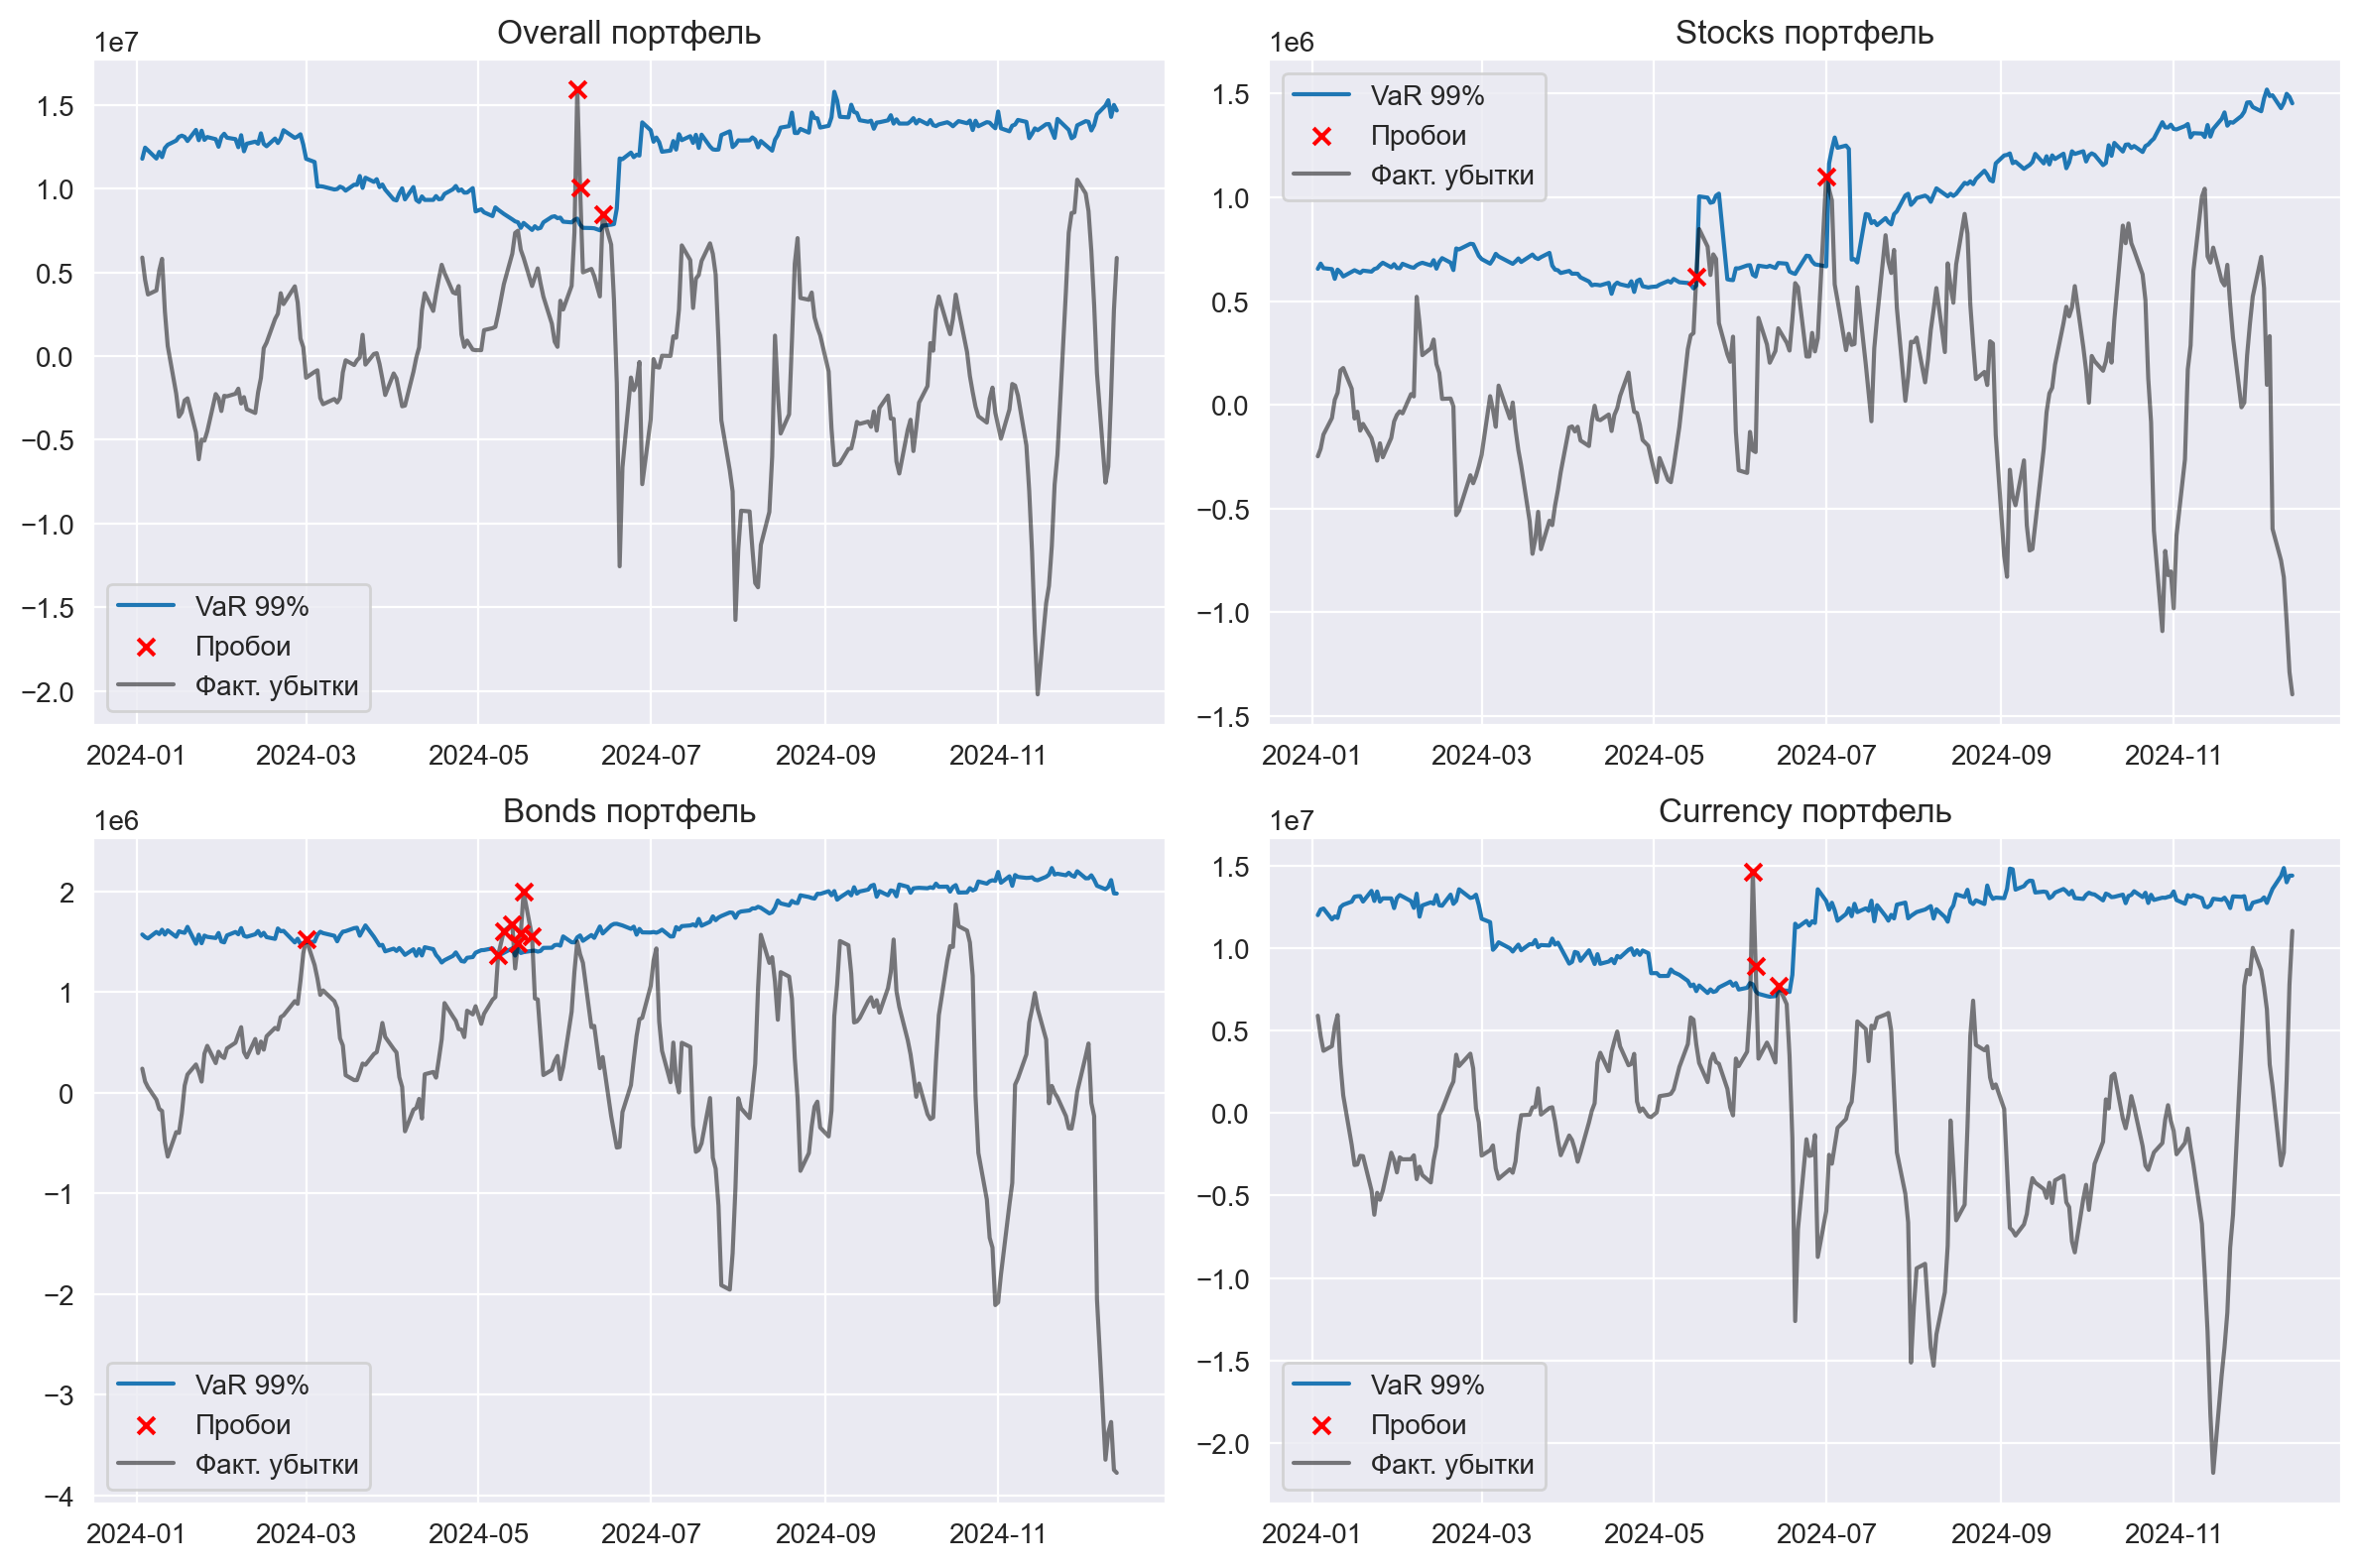

In [63]:
HORIZON_DAYS = 10
ALPHA_VAR = 0.99
ALPHA_ES = 0.975
NSIM = 5000
WINDOW_SIZE = 140

shares_weights = {stock: 1e6 for stock in market_set}
bonds_weights = {bond: 10e6 for bond in debt_set}
currency_weights = {curr: 100e6 for curr in currency_set}

results_10d = {
    'overall': {'date': [], 'var_99': [], 'es_97_5': [], 'actual_loss': []},
    'stocks': {'date': [], 'var_99': [], 'es_97_5': [], 'actual_loss': [], 'correction_factor': []},
    'bonds': {'date': [], 'var_99': [], 'es_97_5': [], 'actual_loss': []},
    'currency': {'date': [], 'var_99': [], 'es_97_5': [], 'actual_loss': []}
}


stock_correction_factors_10d = []
stock_exception_history_10d = []


for i, date in tqdm(enumerate(pd.date_range('2024-01-01', '2024-12-15')), total=len(pd.date_range('2024-01-01', '2024-12-15'))):
    if date not in data['begin'].values:
        continue
    
    idx = data.index[data['begin'] == date][0]
    if idx + 10 >= len(data): 
        continue
    
    history_data = data[data['begin'] <= date]
    window_size = 140  
    asset_columns = market_set + debt_set + currency_set
    recent_data = history_data.iloc[-window_size:][asset_columns]
    
    asset_returns = np.log(recent_data / recent_data.shift(1)).dropna()
    
    mu_assets = asset_returns.mean() * 252
    sigma_assets = asset_returns.std() * np.sqrt(252)
    

    corr_matrix_assets = asset_returns.corr().values
    
    current_prices = data.iloc[idx][asset_columns]
    positions = {
        **{stock: shares_weights[stock] / current_prices[stock] for stock in market_set},
        **{bond: bonds_weights[bond] / current_prices[bond] for bond in debt_set},
        **{curr: currency_weights[curr] / current_prices[curr] for curr in currency_set}
    }
    
    df_values = []
    for asset in asset_columns:
        returns = asset_returns[asset].dropna()
        if len(returns) > 30:
            kurt = returns.kurtosis()
            df_val = max(6 - kurt, 3)
            df_values.append(df_val)
        else:
            df_values.append(4)
    df_mean = np.mean(df_values)
    
    current_prices_list = current_prices.values
    prices_sim = multi_asset_gbm_t_simulations(
        S0_list=current_prices_list,
        mu_list=mu_assets.values,
        sigma_list=sigma_assets.values,
        corr_matrix=corr_matrix_assets,
        T=HORIZON_DAYS/252, 
        N=HORIZON_DAYS, 
        n_simulations=5000,  
        seed=42, 
        df=df_mean
    )
    
    simulated_prices_10d = {}
    for idx_asset, asset in enumerate(asset_columns):
        simulated_prices_10d[asset] = prices_sim[:, idx_asset, 10]  
    
    for portfolio, assets in zip(
        ['stocks', 'bonds', 'currency', 'overall'],
        [market_set, debt_set, currency_set, market_set + debt_set + currency_set]
    ):
        current_value = sum(positions[asset] * current_prices[asset] for asset in assets)
        
        sim_portfolio_values_10d = np.zeros(5000)
        for asset in assets:
            sim_portfolio_values_10d += positions[asset] * simulated_prices_10d[asset]
        
        sim_losses_10d = current_value - sim_portfolio_values_10d
        
        prices_10d = data.iloc[idx+10][assets]
        value_10d = sum(positions[asset] * prices_10d[asset] for asset in assets)
        actual_loss_10d = current_value - value_10d
        
        if portfolio == 'stocks':
            var_99 = np.percentile(sim_losses_10d, 99)
            es_97_5 = np.percentile(sim_losses_10d, 99.5)  
            
            if len(stock_exception_history_10d) > 6: 
                recent_exceptions = sum(stock_exception_history_10d[-6:])
                expected_exceptions = 0.01 * len(stock_exception_history_10d[-6:])
                
                if recent_exceptions > expected_exceptions:
                    excess_ratio = recent_exceptions / max(expected_exceptions, 0.1)
                    correction_factor = min(1.8, 1 + (excess_ratio - 1) * 0.3)
                    var_99 *= correction_factor
                    results_10d['stocks']['correction_factor'].append(correction_factor)
                else:
                    results_10d['stocks']['correction_factor'].append(1.0)
            else:
                results_10d['stocks']['correction_factor'].append(1.0)
            
            is_exception = 1 if actual_loss_10d > var_99 else 0
            stock_exception_history_10d.append(is_exception)
        else:
            var_99 = np.percentile(sim_losses_10d, 99)
            tail_losses = sim_losses_10d[sim_losses_10d >= np.percentile(sim_losses_10d, 97.5)]
            es_97_5 = tail_losses.mean() if len(tail_losses) > 0 else np.nan
        
        results_10d[portfolio]['date'].append(date)
        results_10d[portfolio]['var_99'].append(var_99)
        results_10d[portfolio]['es_97_5'].append(es_97_5)
        results_10d[portfolio]['actual_loss'].append(actual_loss_10d)

for portfolio in results_10d:
    results_10d[portfolio] = pd.DataFrame(results_10d[portfolio])

plt.figure(figsize=(12, 8))
for i, portfolio in enumerate(['overall', 'stocks', 'bonds', 'currency'], 1):
    plt.subplot(2, 2, i)
    df = results_10d[portfolio]
    plt.plot(df['date'], df['var_99'], label='VaR 99%')
    mask = df['actual_loss'] > df['var_99']

    plt.scatter(df['date'][mask], df['actual_loss'][mask],
                color='red', marker='x', label='Пробои', zorder=3)
    plt.plot(df['date'], df['actual_loss'], 'k-', alpha=0.5, label='Факт. убытки')
    plt.title(f"{portfolio.capitalize()} портфель")
    plt.legend()
plt.tight_layout()
plt.show()


In [64]:
quality_report = generate_quality_report(results_10d)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
quality_report

portfolio  alpha                      test  statistic       p_value      conclusion                                            details                                     interpretation
0      bonds   0.99      Christoffersen (Ind)  27.639216  1.461848e-07     Отвергается                      Тест на независимость пробоев  Обнаружена кластеризация пробоев (риск не расп...
1      bonds   0.99  Christoffersen-Pelletier   5.743921  1.654582e-02     Отвергается  Тест на распределение длительностей между проб...  Обнаружена кластеризация или анти-кластеризаци...
2      bonds   0.99     Engle-Manganelli (DQ)  92.918021  0.000000e+00     Отвергается             Тест на правильную спецификацию модели  Модель неверно специфицирована (пропускает важ...
3      bonds   0.99               Kupiec (UC)   8.008064  4.656949e-03     Отвергается                  Пробоев: 8 (3.28%), Ожидаемо: 2.4  Модель неверно оценивает частоту пробоев (слиш...
4   currency   0.99      Christoffersen (Ind)   5.377166  2.040200e-02     Отвергается                      Тест на независимость пробоев  Обнаружена кластеризация пробоев (риск не расп...
5   currency   0.99  Christoffersen-Pelletier   0.399153  5.275272e-01  Не отвергается  Тест на распределение длительностей между проб...  Распределение длительностей между пробоями соо...
6   currency   0.99     Engle-Manganelli (DQ)  31.405333  6.983641e-07     Отвергается             Тест на правильную спецификацию модели  Модель неверно специфицирована (пропускает важ...
7   currency   0.99               Kupiec (UC)   0.120985  7.279689e-01  Не отвергается                  Пробоев: 3 (1.23%), Ожидаемо: 2.4         Модель правильно оценивает частоту пробоев
8    overall   0.99      Christoffersen (Ind)   5.377166  2.040200e-02     Отвергается                      Тест на независимость пробоев  Обнаружена кластеризация пробоев (риск не расп...
9    overall   0.99  Christoffersen-Pelletier   0.399153  5.275272e-01  Не отвергается  Тест на распределение длительностей между проб...  Распределение длительностей между пробоями соо...
10   overall   0.99     Engle-Manganelli (DQ)  30.748468  9.602819e-07     Отвергается             Тест на правильную спецификацию модели  Модель неверно специфицирована (пропускает важ...
11   overall   0.99               Kupiec (UC)   0.120985  7.279689e-01  Не отвергается                  Пробоев: 3 (1.23%), Ожидаемо: 2.4         Модель правильно оценивает частоту пробоев
12    stocks   0.99      Christoffersen (Ind)   0.033195  8.554289e-01  Не отвергается                      Тест на независимость пробоев              Пробои независимы (нет кластеризации)
13    stocks   0.99  Christoffersen-Pelletier  16.000786  6.331619e-05     Отвергается  Тест на распределение длительностей между проб...  Обнаружена кластеризация или анти-кластеризаци...
14    stocks   0.99     Engle-Manganelli (DQ)   2.084046  5.551471e-01  Не отвергается             Тест на правильную спецификацию модели                   Модель правильно специфицирована
15    stocks   0.99               Kupiec (UC)   0.085398  7.701119e-01  Не отвергается                  Пробоев: 2 (0.82%), Ожидаемо: 2.4         Модель правильно оценивает частоту пробоев

In [65]:
pivot = quality_report.pivot_table(
    index=['test', 'portfolio'], 
    values=['p_value', 'conclusion'],
    aggfunc='first'
)

pivot.columns = [col for col in pivot.columns]

flat_table = pivot.reset_index()
flat_table

test portfolio      conclusion       p_value
0       Christoffersen (Ind)     bonds     Отвергается  1.461848e-07
1       Christoffersen (Ind)  currency     Отвергается  2.040200e-02
2       Christoffersen (Ind)   overall     Отвергается  2.040200e-02
3       Christoffersen (Ind)    stocks  Не отвергается  8.554289e-01
4   Christoffersen-Pelletier     bonds     Отвергается  1.654582e-02
5   Christoffersen-Pelletier  currency  Не отвергается  5.275272e-01
6   Christoffersen-Pelletier   overall  Не отвергается  5.275272e-01
7   Christoffersen-Pelletier    stocks     Отвергается  6.331619e-05
8      Engle-Manganelli (DQ)     bonds     Отвергается  0.000000e+00
9      Engle-Manganelli (DQ)  currency     Отвергается  6.983641e-07
10     Engle-Manganelli (DQ)   overall     Отвергается  9.602819e-07
11     Engle-Manganelli (DQ)    stocks  Не отвергается  5.551471e-01
12               Kupiec (UC)     bonds     Отвергается  4.656949e-03
13               Kupiec (UC)  currency  Не отвергается  7.279689e-01
14               Kupiec (UC)   overall  Не отвергается  7.279689e-01
15               Kupiec (UC)    stocks  Не отвергается  7.701119e-01

# Без GBM

## 1d

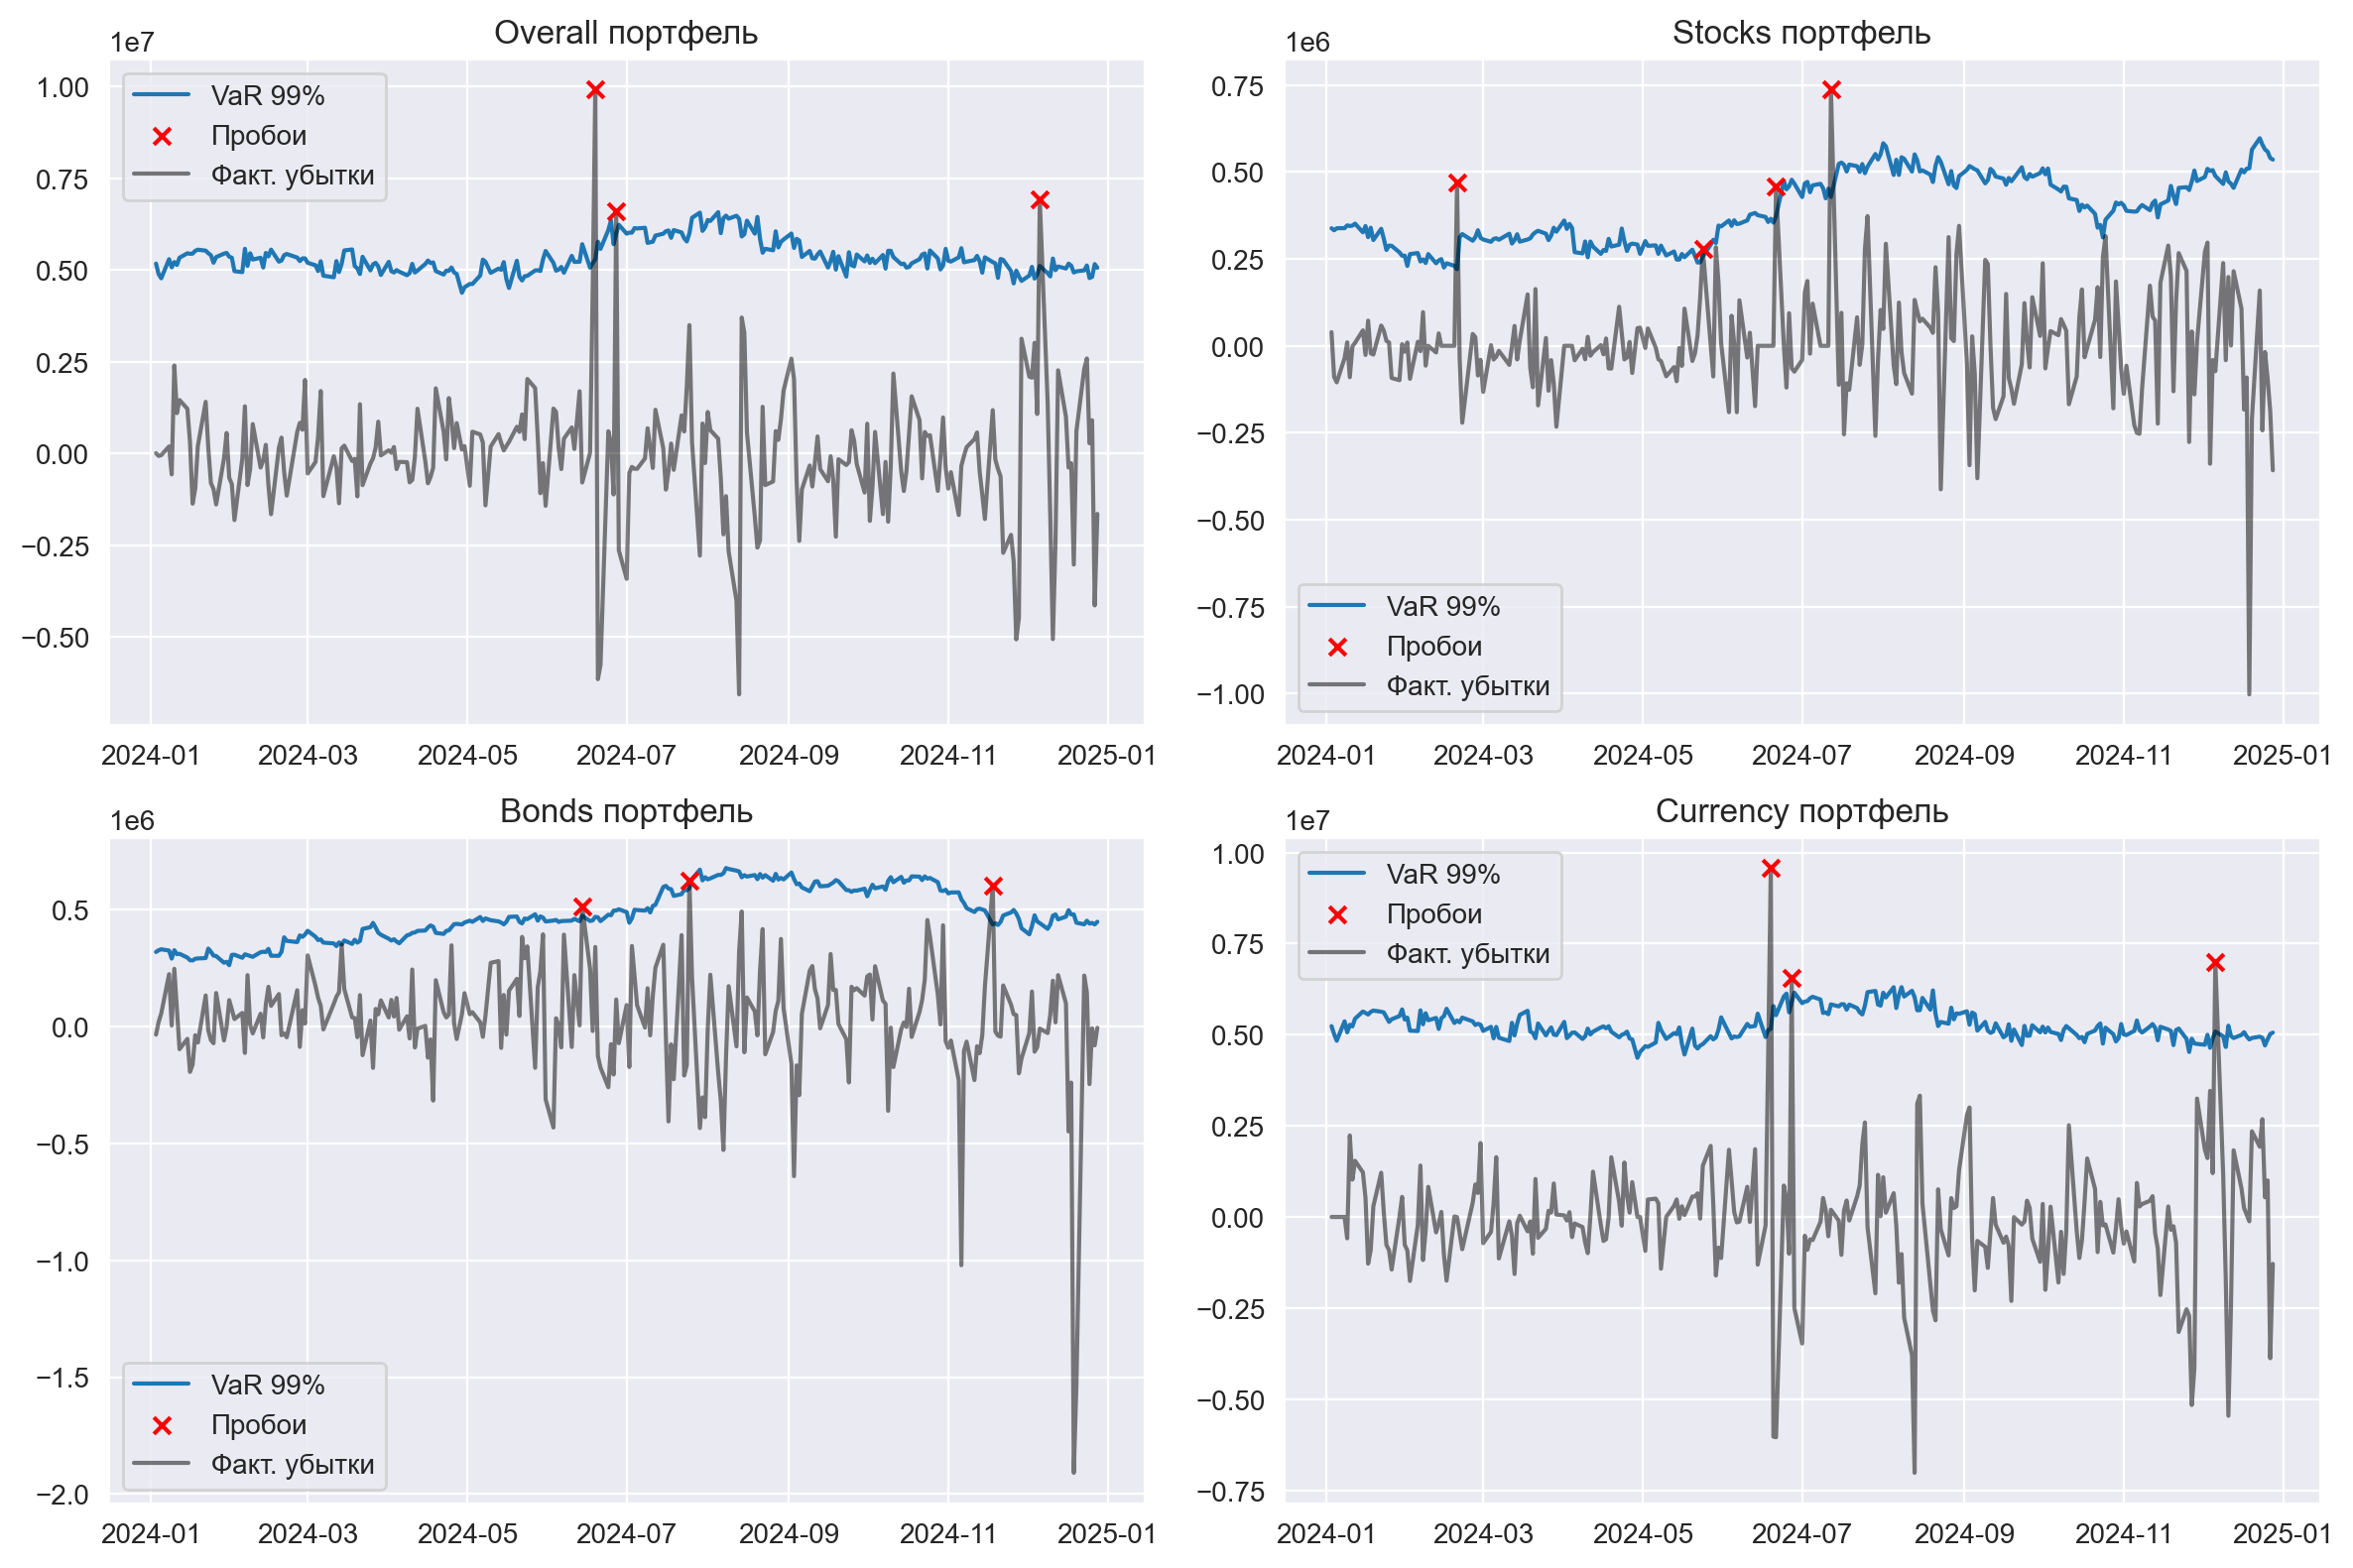

In [66]:
shares_weights = {stock: 1e6 for stock in market_set}
bonds_weights = {bond: 10e6 for bond in debt_set}
currency_weights = {curr: 100e6 for curr in currency_set}

results = {
    'overall': {'date': [], 'var_99': [], 'es_97_5': [], 'actual_loss': []},
    'stocks': {'date': [], 'var_99': [], 'es_97_5': [], 'actual_loss': []},
    'bonds': {'date': [], 'var_99': [], 'es_97_5': [], 'actual_loss': []},
    'currency': {'date': [], 'var_99': [], 'es_97_5': [], 'actual_loss': []}
}

for i, date in enumerate(pd.date_range('2024-01-01', '2024-12-31')):
    if date not in data['begin'].values:
        continue
    
    idx = data.index[data['begin'] == date][0]
    if idx + 1 >= len(data):
        continue
    
    history_data = data[data['begin'] <= date]
    current_risk_factors = risk_factors[risk_factors['begin'] <= date][factor_cols]

    current_prices = data.iloc[idx][market_set + debt_set + currency_set]

    positions = {
        **{stock: shares_weights[stock] / current_prices[stock] for stock in market_set},
        **{bond: bonds_weights[bond] / current_prices[bond] for bond in debt_set},
        **{curr: currency_weights[curr] / current_prices[curr] for curr in currency_set}
    }
    

    window_size = 30
    df_t = 2 

    simulated_prices = {}

    simulated_prices = {}
    current_factors = risk_factors.iloc[idx][factor_cols].values.reshape(1, -1)
    
    for asset in market_set + debt_set + currency_set:
        if asset in currency_set:
            X_train = current_risk_factors.iloc[:-1]  
            y_train = history_data[asset].iloc[1:idx+1]  
            
            model = LinearRegression()
            model.fit(X_train, y_train)
            
            base_pred = model.predict(current_factors)[0]
            
            train_preds = model.predict(X_train)
            residuals = y_train - train_preds
            
            residual_sample = np.random.choice(residuals.values, size=10000, replace=True)
            simulated_prices[asset] = base_pred + residual_sample
            
        elif asset in debt_set:
            returns_window = asset_returns[-90:]
            mu_r = returns_window.mean()
            sigma_r = returns_window.std()

            sigma_r = min(sigma_r, 0.008)

            simulated_returns = np.random.normal(loc=mu_r, scale=sigma_r, size=10000)
            current_price = current_prices[asset]
            simulated_prices[asset] = current_price * np.exp(simulated_returns)

        else:
            asset_returns = np.log(history_data[asset] / history_data[asset].shift(1)).dropna()
            returns_window = asset_returns[-window_size:]
            mu_r = returns_window.mean()
            sigma_r = returns_window.std()

            simulated_returns = t.rvs(df=df_t, loc=mu_r, scale=sigma_r, size=10000)
            current_price = current_prices[asset]
            simulated_prices[asset] = current_price * np.exp(simulated_returns)
    
    current_values = {}
    for portfolio, assets in zip(
        ['stocks', 'bonds', 'currency', 'overall'],
        [market_set, debt_set, currency_set, market_set + debt_set + currency_set]
    ):
        current_value = sum(positions[asset] * current_prices[asset] for asset in assets)
        current_values[portfolio] = current_value
        
        sim_portfolio_values = np.zeros(10000)
        for asset in assets:
            sim_portfolio_values += positions[asset] * simulated_prices[asset]
        
        sim_losses = current_value - sim_portfolio_values
        
        next_prices = data.iloc[idx+1][assets]
        next_value = sum(positions[asset] * next_prices[asset] for asset in assets)
        actual_loss = current_value - next_value
        
        var_99 = np.percentile(sim_losses, 99)
        tail_losses = sim_losses[sim_losses >= np.percentile(sim_losses, 97.5)]
        es_97_5 = tail_losses.mean()
        
        results[portfolio]['date'].append(date)
        results[portfolio]['var_99'].append(var_99)
        results[portfolio]['es_97_5'].append(es_97_5)
        results[portfolio]['actual_loss'].append(actual_loss)

for portfolio in results:
    results[portfolio] = pd.DataFrame(results[portfolio])

plt.figure(figsize=(12, 8))
for i, portfolio in enumerate(['overall', 'stocks', 'bonds', 'currency'], 1):
    plt.subplot(2, 2, i)
    df = results[portfolio]
    plt.plot(df['date'], df['var_99'], label='VaR 99%')
    mask = df['actual_loss'] > df['var_99']

    plt.scatter(df['date'][mask], df['actual_loss'][mask],
                color='red', marker='x', label='Пробои', zorder=3)
    plt.plot(df['date'], df['actual_loss'], 'k-', alpha=0.5, label='Факт. убытки')
    plt.title(f"{portfolio.capitalize()} портфель")
    plt.legend()
plt.tight_layout()
plt.show()


In [69]:
quality_report = generate_quality_report(results)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
quality_report

portfolio  alpha                      test  statistic   p_value      conclusion                                            details                                     interpretation
0      bonds   0.99      Christoffersen (Ind)   0.071715  0.788856  Не отвергается                      Тест на независимость пробоев              Пробои независимы (нет кластеризации)
1      bonds   0.99  Christoffersen-Pelletier   1.489957  0.222223  Не отвергается  Тест на распределение длительностей между проб...  Распределение длительностей между пробоями соо...
2      bonds   0.99     Engle-Manganelli (DQ)   0.155058  0.984496  Не отвергается             Тест на правильную спецификацию модели                   Модель правильно специфицирована
3      bonds   0.99               Kupiec (UC)   0.075916  0.782910  Не отвергается                  Пробоев: 3 (1.18%), Ожидаемо: 2.6         Модель правильно оценивает частоту пробоев
4   currency   0.99      Christoffersen (Ind)   0.071715  0.788856  Не отвергается                      Тест на независимость пробоев              Пробои независимы (нет кластеризации)
5   currency   0.99  Christoffersen-Pelletier   0.136685  0.711599  Не отвергается  Тест на распределение длительностей между проб...  Распределение длительностей между пробоями соо...
6   currency   0.99     Engle-Manganelli (DQ)   0.348838  0.950596  Не отвергается             Тест на правильную спецификацию модели                   Модель правильно специфицирована
7   currency   0.99               Kupiec (UC)   0.075916  0.782910  Не отвергается                  Пробоев: 3 (1.18%), Ожидаемо: 2.6         Модель правильно оценивает частоту пробоев
8    overall   0.99      Christoffersen (Ind)   0.071715  0.788856  Не отвергается                      Тест на независимость пробоев              Пробои независимы (нет кластеризации)
9    overall   0.99  Christoffersen-Pelletier   0.136685  0.711599  Не отвергается  Тест на распределение длительностей между проб...  Распределение длительностей между пробоями соо...
10   overall   0.99     Engle-Manganelli (DQ)   0.278747  0.963975  Не отвергается             Тест на правильную спецификацию модели                   Модель правильно специфицирована
11   overall   0.99               Kupiec (UC)   0.075916  0.782910  Не отвергается                  Пробоев: 3 (1.18%), Ожидаемо: 2.6         Модель правильно оценивает частоту пробоев
12    stocks   0.99      Christoffersen (Ind)   0.128005  0.720509  Не отвергается                      Тест на независимость пробоев              Пробои независимы (нет кластеризации)
13    stocks   0.99  Christoffersen-Pelletier   0.842061  0.358808  Не отвергается  Тест на распределение длительностей между проб...  Распределение длительностей между пробоями соо...
14    stocks   0.99     Engle-Manganelli (DQ)   2.379318  0.497496  Не отвергается             Тест на правильную спецификацию модели                   Модель правильно специфицирована
15    stocks   0.99               Kupiec (UC)   0.709952  0.399460  Не отвергается                  Пробоев: 4 (1.57%), Ожидаемо: 2.6         Модель правильно оценивает частоту пробоев

In [68]:
pivot = quality_report.pivot_table(
    index=['test', 'portfolio'], 
    values=['p_value', 'conclusion'],
    aggfunc='first'
)

pivot.columns = [col for col in pivot.columns]

flat_table = pivot.reset_index()
flat_table

test portfolio      conclusion   p_value
0       Christoffersen (Ind)     bonds  Не отвергается  0.788856
1       Christoffersen (Ind)  currency  Не отвергается  0.788856
2       Christoffersen (Ind)   overall  Не отвергается  0.788856
3       Christoffersen (Ind)    stocks  Не отвергается  0.720509
4   Christoffersen-Pelletier     bonds  Не отвергается  0.222223
5   Christoffersen-Pelletier  currency  Не отвергается  0.711599
6   Christoffersen-Pelletier   overall  Не отвергается  0.711599
7   Christoffersen-Pelletier    stocks  Не отвергается  0.358808
8      Engle-Manganelli (DQ)     bonds  Не отвергается  0.984496
9      Engle-Manganelli (DQ)  currency  Не отвергается  0.950596
10     Engle-Manganelli (DQ)   overall  Не отвергается  0.963975
11     Engle-Manganelli (DQ)    stocks  Не отвергается  0.497496
12               Kupiec (UC)     bonds  Не отвергается  0.782910
13               Kupiec (UC)  currency  Не отвергается  0.782910
14               Kupiec (UC)   overall  Не отвергается  0.782910
15               Kupiec (UC)    stocks  Не отвергается  0.399460